## Shedding some light on used car prices

My wife and I were in the market to replace a car. It's one of the bigger financial decisions people make on a regular basis so I wanted to make a smart choice. There are reviews online and you can get a sense of prices by shopping around. But I wanted to know more. This post will walk you through some exploratory analysis I did to answer these questions:

1. How do used car prices trend with mileage? 
2. How do these trends differ between similar car models and model years?
3. What mileage should I buy a car at to get the best value?
3. How does a hybrid compare in long term value compared to a standard sedan?

And I can answer most of these questions with Kelley Blue Book. They have a wide range of market price estimates for any car model/year/mileage/condition. And as it turns out, their web pages have that information pretty easily accessible in the HTML. So we can rig up a simple web scraper and get the info we need! 

Below I'll explain of how I got this data and and how I analyzed it. I'm experimenting with embedded code blocks so I'll include example code along the way.

## Step 1: Getting Data from KBB

First of all, what data do we want? The cars I'm interested in are the following:

- Honda Civic
- Hyundai Elantra
- Toyota Carolla
- Ford Fusion
- Honda Insight
- Toyota Prius

The list consists of a few standard compact sedans and a few basic hybrid models. I wanted to buy a ~5 year old used car, so I targeted 2010, 2011 and 2012 models. I found www.kbb.com results for each of these combinations of model/year and used the following code to extract pricing information for each.

In [73]:
# define what mileage values I want to pull a price for
# in this case, ever 10k miles between 10k and 130k
mileages = range(10000, 230000+10000, 10000)

# these parameters don't matter. they specify 
# what condition of vehicle to pull up on kbb, but 
# each kbb page contains numbers for all conditions
condition = 'verygood'
pricetype = 'retail'
intent = 'buy-used'

# price estimates vary by zip code so you have to specify
zipcode = '11961'

#initialize a root dictionary containing car info.
#the root index will specify car model
#the next level index will specify model year
#each model year then contains a set of variables with values (leaves)
scraped_data = {}

# I had to manually look up the URL for each car model/year on kbb as they are non standard
# if you want to add a different car, you have to go look on kbb and define a dictionary 
# entry similar to those below

# http://www.kbb.com/hyundai/elantra/2010/gls-sedan-4d/?vehicleid=261559&category=sedan
# http://www.kbb.com/hyundai/elantra/2011/gls-sedan-4d/?vehicleid=352613&category=sedan
# http://www.kbb.com/hyundai/elantra/2012/gls-sedan-4d/?vehicleid=364017&category=sedan
car = 'elantra'
scraped_data[car] = {}
scraped_data[car][2010] = {}
scraped_data[car][2010]['path'] = 'hyundai/elantra/2010/gls-sedan-4d'
scraped_data[car][2010]['vehicleid'] = 261559
scraped_data[car][2011] = {}
scraped_data[car][2011]['path'] = 'hyundai/elantra/2011/gls-sedan-4d'
scraped_data[car][2011]['vehicleid'] = 352613
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'hyundai/elantra/2012/gls-sedan-4d'
scraped_data[car][2012]['vehicleid'] = 364017
for year in scraped_data[car]:
    scraped_data[car][year]['category'] = 'sedan'
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'economic car'

# http://www.kbb.com/toyota/prius/2010/i-hatchback-4d/?vehicleid=261967&category=hatchback
# http://www.kbb.com/toyota/prius/2011/two-hatchback-4d/?vehicleid=363079&category=hatchback
# http://www.kbb.com/toyota/prius/2012/two-hatchback-4d/?vehicleid=373443&category=hatchback
car = 'prius'
scraped_data[car] = {}
scraped_data[car][2010] = {}
scraped_data[car][2010]['path'] = 'toyota/prius/2010/i-hatchback-4d'
scraped_data[car][2010]['vehicleid'] = 261967
scraped_data[car][2011] = {}
scraped_data[car][2011]['path'] = 'toyota/prius/2011/two-hatchback-4d'
scraped_data[car][2011]['vehicleid'] = 363079
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'toyota/prius/2012/two-hatchback-4d'
scraped_data[car][2012]['vehicleid'] = 373443
for year in scraped_data[car]:
    scraped_data[car][year]['category'] = 'hatchback'
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'hybrid car'

# http://www.kbb.com/honda/insight/2010/lx-hatchback-4d/?vehicleid=251583&swop=false&category=hatchback
# http://www.kbb.com/honda/insight/2011/lx-hatchback-4d/?vehicleid=360124&swop=false&category=hatchback
# http://www.kbb.com/honda/insight/2012/lx-hatchback-4d/?vehicleid=371307&swop=false&category=hatchback
car = 'insight'
scraped_data[car] = {}
scraped_data[car][2010] = {}
scraped_data[car][2010]['path'] = 'honda/insight/2010/lx-hatchback-4d'
scraped_data[car][2010]['vehicleid'] = 251583
scraped_data[car][2011] = {}
scraped_data[car][2011]['path'] = 'honda/insight/2011/lx-hatchback-4d'
scraped_data[car][2011]['vehicleid'] = 360124
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'honda/insight/2012/lx-hatchback-4d'
scraped_data[car][2012]['vehicleid'] = 371307
for year in scraped_data[car]:
    scraped_data[car][year]['category'] = 'hatchback'
    scraped_data[car][year]['swop'] = 'false'
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'hybrid car'

# http://www.kbb.com/toyota/corolla/2010/sedan-4d/?vehicleid=261636&category=sedan
# http://www.kbb.com/toyota/corolla/2011/sedan-4d/?vehicleid=360136&category=sedan
# http://www.kbb.com/toyota/corolla/2012/le-sedan-4d/?vehicleid=371591&category=sedan
car = 'corolla'
scraped_data[car] = {}
scraped_data[car][2010] = {}
scraped_data[car][2010]['path'] = 'toyota/corolla/2010/sedan-4d'
scraped_data[car][2010]['vehicleid'] = 261636
scraped_data[car][2011] = {}
scraped_data[car][2011]['path'] = 'toyota/corolla/2011/sedan-4d'
scraped_data[car][2011]['vehicleid'] = 360136
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'toyota/corolla/2012/le-sedan-4d'
scraped_data[car][2012]['vehicleid'] = 371591
for year in scraped_data[car]:
    scraped_data[car][year]['category'] = 'sedan'
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'economic car'

# http://www.kbb.com/honda/civic/2010/dx-sedan-4d/?vehicleid=261537&category=sedan
# http://www.kbb.com/honda/civic/2011/dx-sedan-4d/?vehicleid=358177&category=sedan
# http://www.kbb.com/honda/civic/2012/dx-sedan-4d/?vehicleid=371048&category=sedan
car = 'civic'
scraped_data[car] = {}
scraped_data[car][2010] = {}
scraped_data[car][2010]['path'] = 'honda/civic/2010/dx-sedan-4d'
scraped_data[car][2010]['vehicleid'] = 261537
scraped_data[car][2011] = {}
scraped_data[car][2011]['path'] = 'honda/civic/2011/dx-sedan-4d'
scraped_data[car][2011]['vehicleid'] = 358177
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'honda/civic/2012/dx-sedan-4d'
scraped_data[car][2012]['vehicleid'] = 371048
for year in scraped_data[car]:
    scraped_data[car][year]['category'] = 'sedan'
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'economic car'

# ford/fusion/2010/hybrid-sedan-4d/?vehicleid=248464
# ford/fusion/2011/hybrid-sedan-4d/?vehicleid=352866
# ford/fusion/2012/hybrid-sedan-4d/?vehicleid=364410
car = 'fusion-hybrid'
scraped_data[car] = {}
scraped_data[car][2010] = {}
scraped_data[car][2010]['path'] = 'ford/fusion/2010/hybrid-sedan-4d'
scraped_data[car][2010]['vehicleid'] = 248464
scraped_data[car][2011] = {}
scraped_data[car][2011]['path'] = 'ford/fusion/2011/hybrid-sedan-4d'
scraped_data[car][2011]['vehicleid'] = 352866
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'ford/fusion/2012/hybrid-sedan-4d'
scraped_data[car][2012]['vehicleid'] = 364410
for year in scraped_data[car]:
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'hybrid car'
    
#toyota/prius-c/2012/three-hatchback-4d-specifications/?vehicleid=374558&intent
car = 'prius-c'
scraped_data[car] = {}
scraped_data[car][2012] = {}
scraped_data[car][2012]['path'] = 'toyota/prius-c/2012/three-hatchback-4d'
scraped_data[car][2012]['vehicleid'] = 374558
for year in scraped_data[car]:
    scraped_data[car][year]['category'] = 'hatchback'
    scraped_data[car][year]['mileage'] = []
    scraped_data[car][year]['prices'] = []
    scraped_data[car][year]['condition'] = condition
    scraped_data[car][year]['type'] = 'hybrid car'

In [ ]:
from bs4 import BeautifulSoup
import requests
import json
import shelve

# loop through the dictionary indicies (model/year) and pull info from kbb
for car in scraped_data:
    for year in scraped_data[car]:
        for mileage in mileages:
            print '<%d-%s>: Reading url for car with %s miles:' % (year, car, mileage)
            
            
            # To find the proper kbb URL for each car permutation, I looked at the 
            # URL's manually to figure out the formatting and define a string accordingly
            url = 'http://www.kbb.com/%s/' % scraped_data[car][year]['path']
            url += '?vehicleid=%s&' % scraped_data[car][year]['vehicleid']
            if 'category' in scraped_data[car][year]:
                url += 'category=%s&' % scraped_data[car][year]['category']
            url += 'mileage=%s&' % mileage
            url += 'condition=%s&' % condition
            url += 'intent=%s&' % intent
            url += 'pricetype=%s' % pricetype

            print '<%d-%s>: ' % (year, car), url
            
            # the header isn't strictly necessary but makes it look like you're actually 
            # pulling the web page from a browser, not from a script
            headers = {'User-Agent': \
                 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 '+\
                 '(KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36'}            
            
            # Get the page HTML. here we use 'requests', but 'urllib' and 
            # 'mechanize' are other package options the cookie parameter is 
            # included match the cookie I noticed specifying zip code on kbb.com
            html = requests.get(url, 
                                cookies={'ZipCode': zipcode}, 
                                headers=headers).text
            
            # load the html in to beautiful soup
            soup = BeautifulSoup(html)
            
            print '<%d-%s>: webpage loading complete. parsing...' % (year, car)

            # I'm expecting there to be only one html <script> element that has these
            # attributes. I manually looked in the webpage source and searched for the number
            # matching what was displayed on the webpage to identify the element
            # with the pricing info of interest
            element = soup.find('script', 
                                attrs={'type': 'text/javascript', 
                                       'language': 'javascript'})

            #make sure the string isn't empty
            if element.string:
                # make sure it contains the content we expect
                if element.string.lstrip()[:18] == '$(document).ready(':
                    # strip white space
                    full_str = element.string.lstrip()

                    # I found that this HTML container contained text
                    # that specified prices for different seller conditions
                    # in a json format. So by counting the right number of lines
                    # I can get the pricing data directly. Sometimes there were 
                    # was extra lines included, hence the 37/32 try-except. 
                    try:
                        line_count = 0
                        count_limit = 37
                        save_lines=False

                        # the princing info will be added in this string
                        json_data = ''

                        for line in full_str.splitlines():
                            # the word values indicated where pricing info starts
                            if line.lstrip()[1:7] == 'values':
                                save_lines = True

                            if save_lines:
                                json_data += line.lstrip()

                                line_count += 1
                                if line_count >= count_limit:
                                    save_lines = False

                        # tack on braces for final json formatting
                        json_data = '{' + json_data[:-1] + '}'
                        
                        # this doesn't actually do anything now but will throw 
                        # the error we want to catch if it's supposed to be 32 lines
                        json.loads(json_data)
                    except:
                        line_count = 0
                        count_limit = 32
                        save_lines=False

                        # the princing info will be added in this string
                        json_data = ''

                        for line in full_str.splitlines():
                            # the word values indicated where pricing info starts
                            if line.lstrip()[1:7] == 'values':
                                save_lines = True

                            if save_lines:
                                json_data += line.lstrip()

                                line_count += 1
                                if line_count >= count_limit:
                                    save_lines = False

                        # tack on braces for final json formatting
                        json_data = '{' + json_data[:-1] + '}'

                    # de-serialize the json string in to a dictionary (with 2 indices) 
                    # specifying prices under different conditions
                    scraped_data[car][year]['prices'].append(json.loads(json_data)['values'])
                    
                    scraped_data[car][year]['mileage'].append(int(mileage))
                    
                    print '<%d-%s>: found price info!' % (year, car)
                else:
                    print '<%d-%s>: PROBLEM - FAILED TO FIND PRICE INFO!' % (year, car)
            else:
                print '<%d-%s>: PROBLEM - FAILED TO FIND PRICE INFO!' % (year, car)
            
            print '<%d-%s>: finished loading data!' % (year, car)
            print ''

print 'FINISHED LOADING ALL CARS!'

# now that we have the data, we want to construct a more flat structure
# (i.e. - a single table with non-hierarchical columns) and put it in a dataframe
#
# define a dictionary that will be used to construct the dataframe (indices are columns):
car_prices = {}
car_prices['car'] = []
car_prices['year'] = []
car_prices['mileage'] = []
car_prices['retail'] = []
car_prices['dealer'] = []
car_prices['dealer_min'] = []
car_prices['dealer_max'] = []
car_prices['pp_fair'] = []
car_prices['pp_good'] = []
car_prices['pp_verygood'] = []
car_prices['pp_excellent'] = []

for car in scraped_data:
    for year in scraped_data[car]:
        for mileage, price in zip(scraped_data[car][year]['mileage'], 
                                  scraped_data[car][year]['prices']):
            car_prices['car'].append(car)
            car_prices['year'].append(year)
            car_prices['mileage'].append(mileage)
            # I manually looked at the 'price' dicitonary structure for this:
            car_prices['retail'].append(price['retail']['price'])
            car_prices['dealer'].append(price['fpp']['price'])
            car_prices['dealer_min'].append(price['fpp']['priceMin'])
            car_prices['dealer_max'].append(price['fpp']['priceMax'])
            car_prices['pp_fair'].append(price['privatepartyfair']['price'])
            car_prices['pp_good'].append(price['privatepartygood']['price'])
            car_prices['pp_verygood'].append(price['privatepartyverygood']['price'])
            car_prices['pp_excellent'].append(price['privatepartyexcellent']['price'])


df = pd.DataFrame(car_prices)
            
# save the scraped data to file so you don't have to scrape it again later
f = shelve.open('scraped_data.shelf', flag='n')
f['df'] = df
f.close()

Now we have prices for all our models and years, for mileages ranging between 10k - 130k miles. And in fact we have a variety of prices for each: retail, used from a dealer, and used from a private party in various conditions (fair/good/very good/excellent). Now to see what we can learn!

## Step 2: Answering Questions

Let's hit the questions one by one. 

1. How do used car prices trend with mileage and model year? 
2. How do these trends differ between similar car models?
3. What mileage of car gives the best value?
4. How does a hybrid compare in long term value compared to a standard sedan?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shelve
%matplotlib inline

# load the scraped data from file
f = shelve.open('scraped_data.shelf', flag='r')
df = f['df']
f.close()


# split the dataframe by car model for convenience
data = {}
for car in df['car'].unique():
    data[car] = {}
    data[car][2010] = df[(df['car'] == car) & (df['year'] == 2010)]
    data[car][2011] = df[(df['car'] == car) & (df['year'] == 2011)]
    data[car][2012] = df[(df['car'] == car) & (df['year'] == 2012)]

### 1. How do used car prices trend with mileage and model year?

Below is an example plot of price vs. mileage. The example chosen was the Toyota Corolla for model years 2010, 2011 and 2012 and the price shown is a median used price you'd expect to pay at a dealer. As you can see, the general trends are what you expect: price goes down if you're buying a higher mileage car, and price goes down if you're buying an older model year. 

For a given model year, the trend vs mileage is not exactly linear, but close. As expected, the rate of price decay slows at higher mileage but surprisingly, the rate of price decay is also lower at the lowest mileages. So if you're looking at cars in the range of 20k miles, you'll get a better value if you chose one closer to 10k than if you choose one closer to 30k (but we'll dig deeper in to that choice later). This behavior vs mileage is similar between years and it will turn out it's also similar in shape (but different in slope) between car models.

As for the different model years, the price gets more expensive with respect to year at a greater than linear rate. Also the rate of price decay vs mileage is only slightly different between years. Both of these trends differ between different car models, which will be discussed next.

In [25]:
def mileage_cut(data, mileage):
    subset = {}
    for car in data:
        subset[car] = {}
        for year in data[car]:
            subset[car][year] = data[car][year][data[car][year]['mileage'] <= mileage]
            
    return subset

subset = mileage_cut(data, 130000)

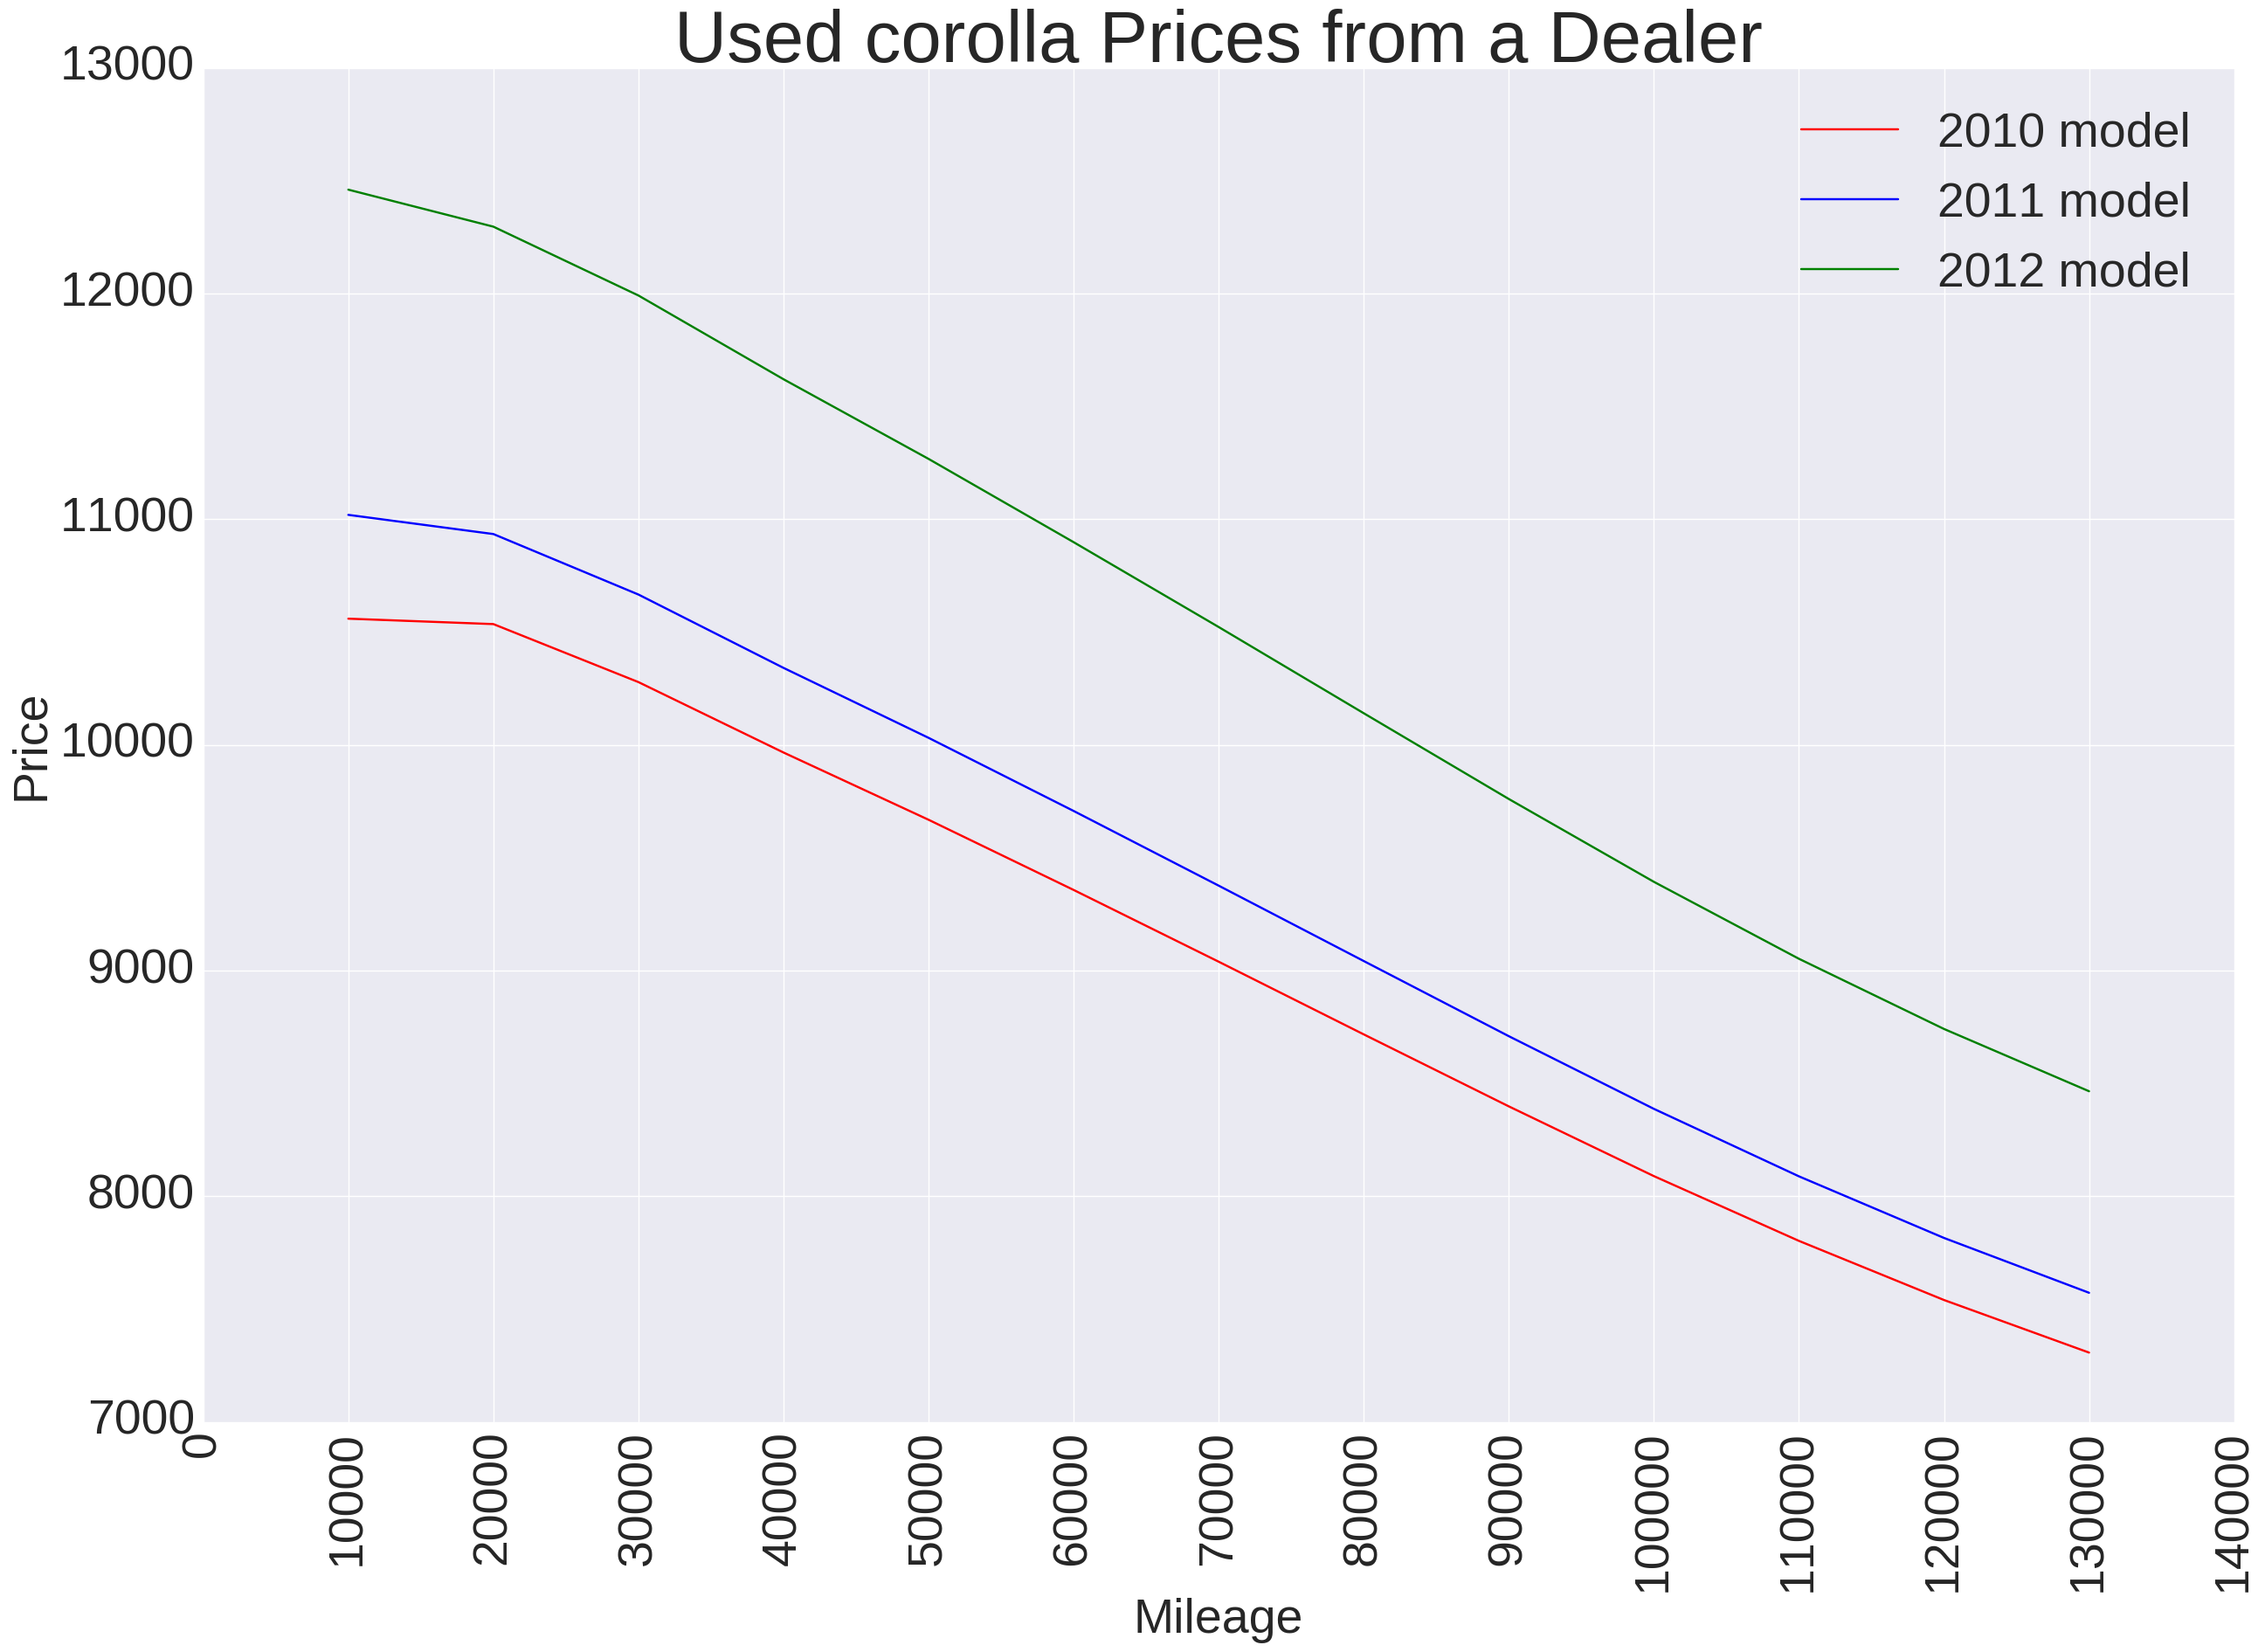

In [2]:
car = 'corolla'
fig, ax = plt.subplots()
height = 20
fig.set_figheight(height)
width = 30
fig.set_figwidth(width)
ax.set_title('Used %s Prices from a Dealer' % car, fontsize=width*2)
ax.set_xlabel('Mileage', fontsize=height*2)
ax.set_ylabel('Price', fontsize=height*2)
ax.tick_params(axis='y', labelsize=height*2)
ax.tick_params(axis='x', labelsize=height*2)
ax.ticklabel_format()

dealer = {}
colors = {2010:'r', 2011:'b', 2012:'g'}

for year in [2010, 2011, 2012]:
    dealer[year] = ax.plot(subset[car][year].mileage, 
                           subset[car][year].dealer, 
                           c=colors[year])

ax.legend([(dealer[2010][0]), 
            (dealer[2011][0]), 
            (dealer[2012][0])
          ], 
           ['2010 model', 
            '2011 model', 
            '2012 model'
           ],
          fontsize=height*2)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+1000, 1000))
plt.xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1]+10000, 10000), 
           range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])+10000, 10000),
          rotation='vertical')

plt.show()

### 2. How do these trends differ between similar car models?

A good way to compare mileage trends between car models is to look at each model on a "low mileage price" vs "high mileage price" plot. This is shown below for our 6 car models of interest - standard sedans are triangles and hybrids are circles. Each region of the plot can be interpreted as labeled: a car being "cheaper" vs "more expensive" is determined by it's position diagonally bottom-left to top-right. and a car's rate of price decay is shown by it's position diagonally top-left to bottom-right.

This gives us a sense of how the car models compare. The Prius is the most expensive while the Civic is the cheapest. And the Corolla tends to be have the slowest price decay, while the Elantra or Fusion-hybrid lose their value faster. All useful information to consider when choosing what to buy!

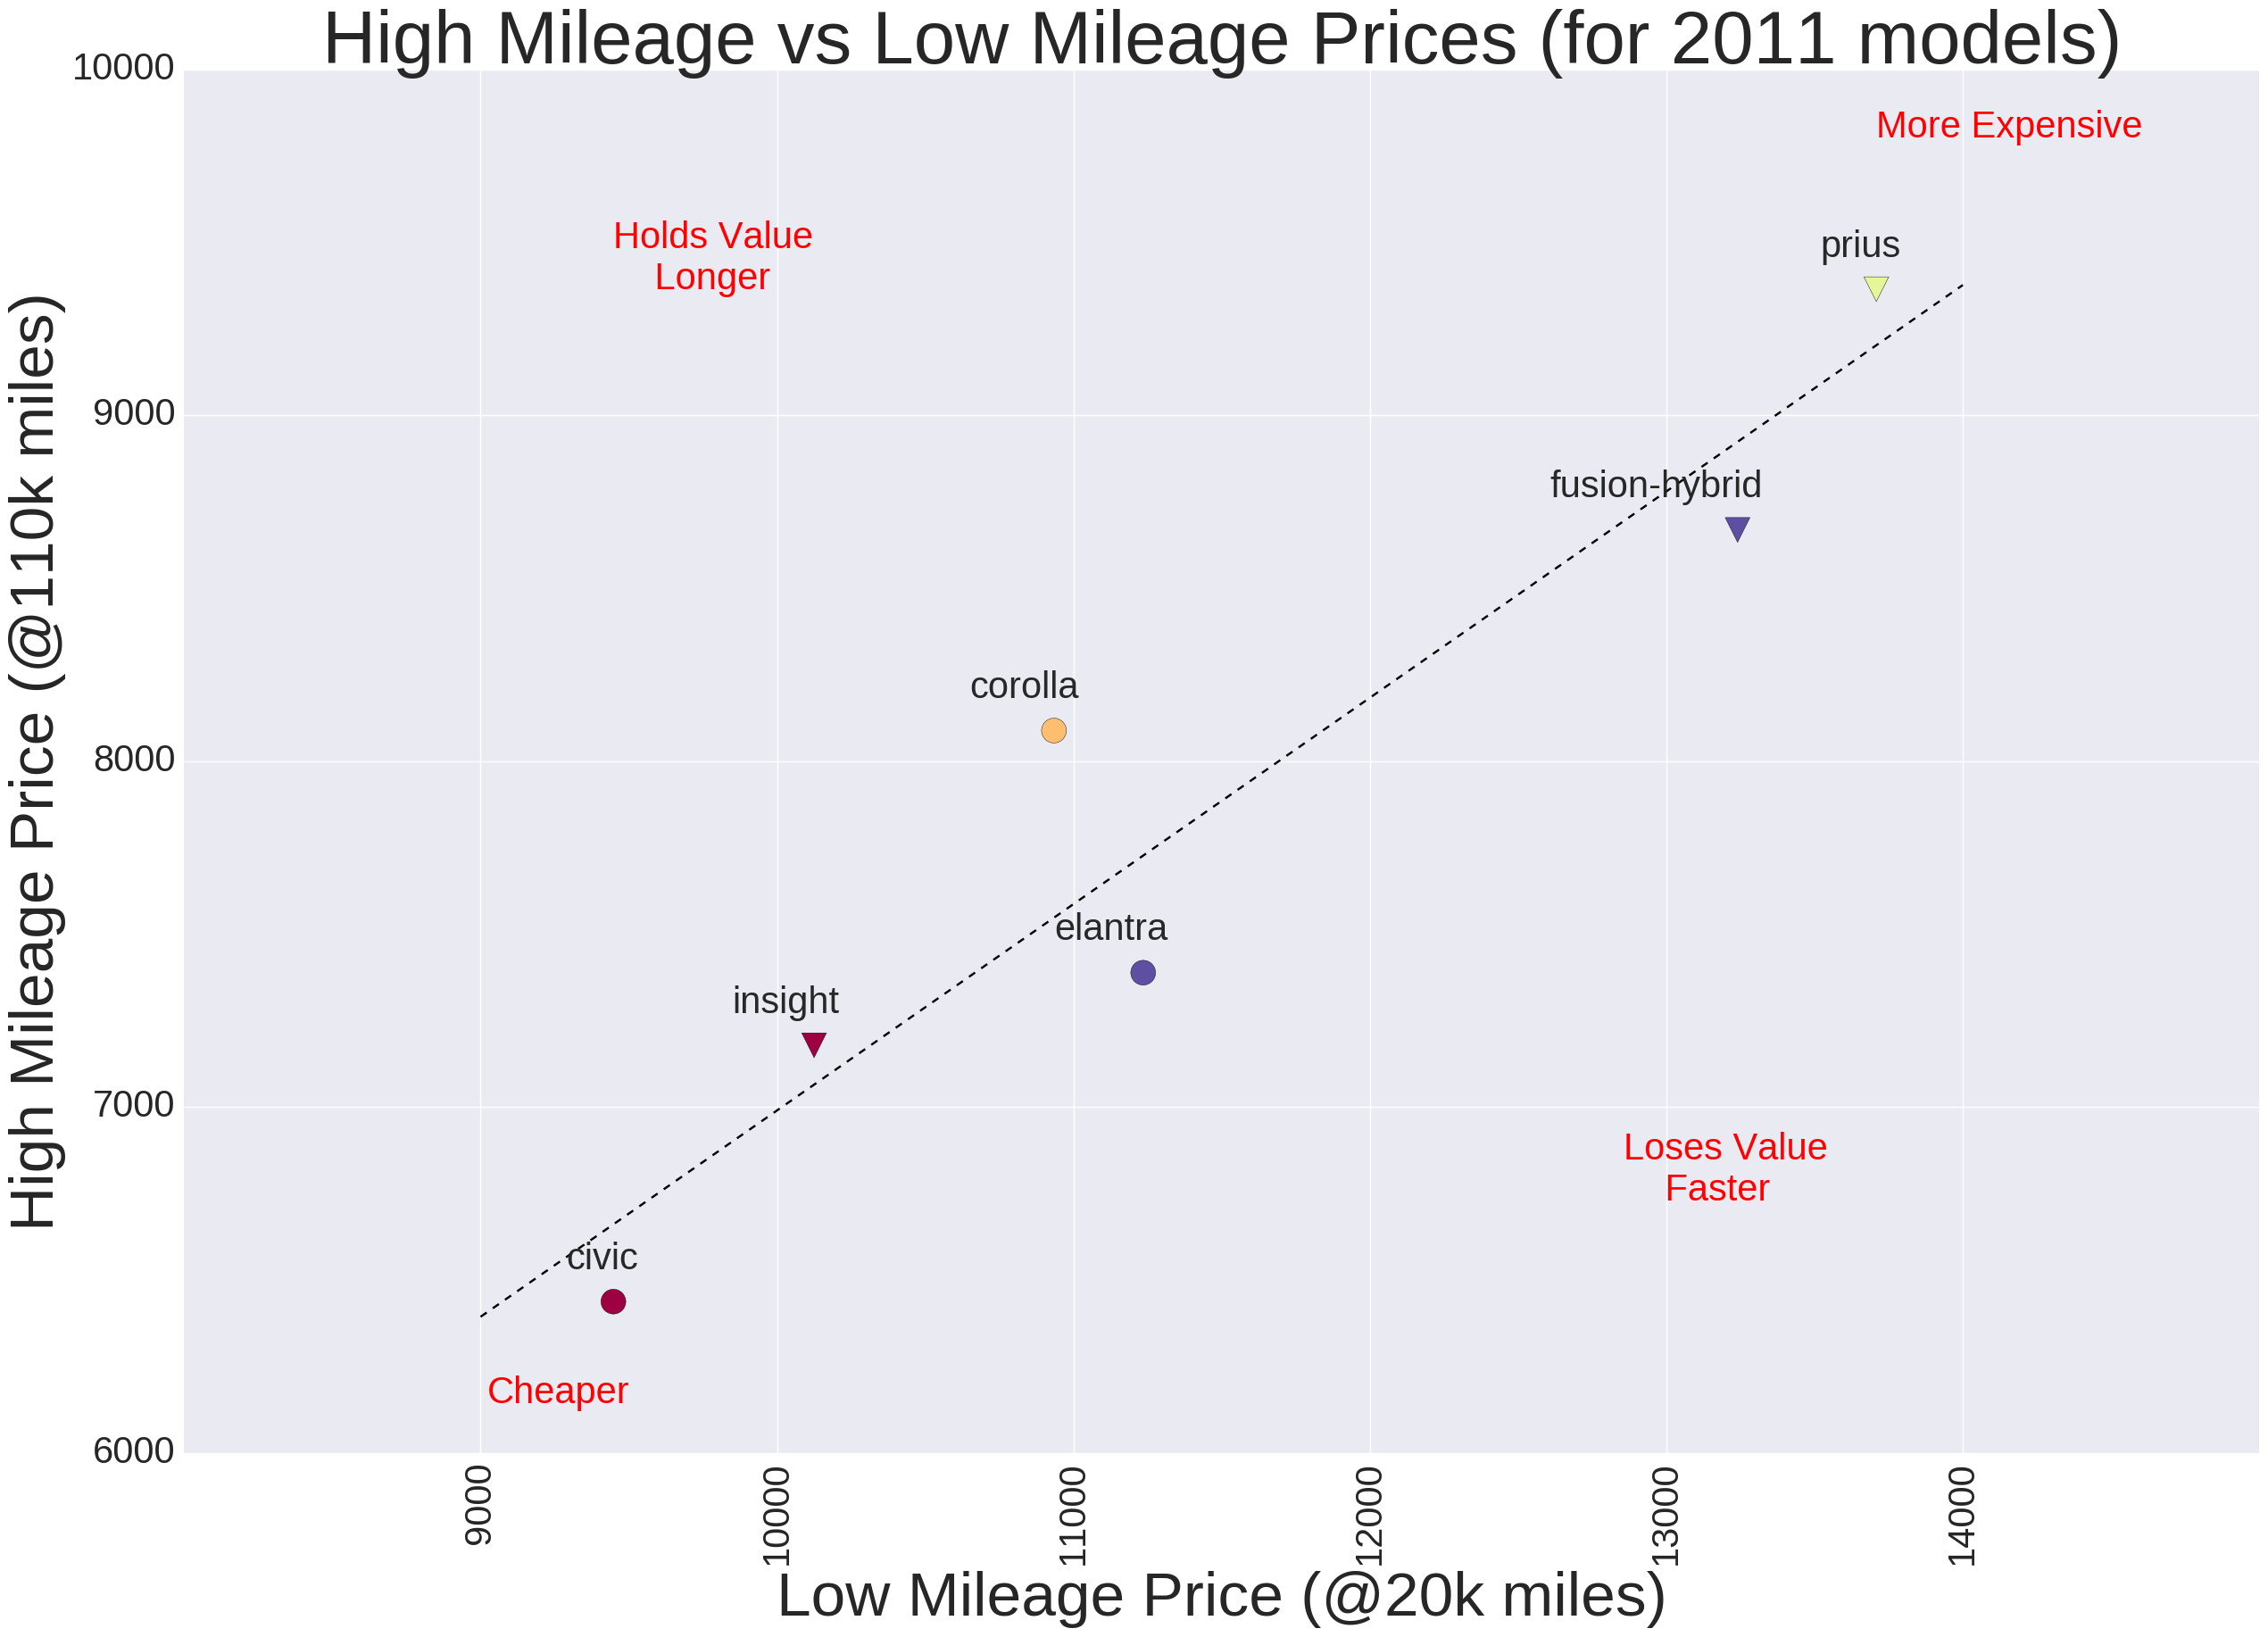

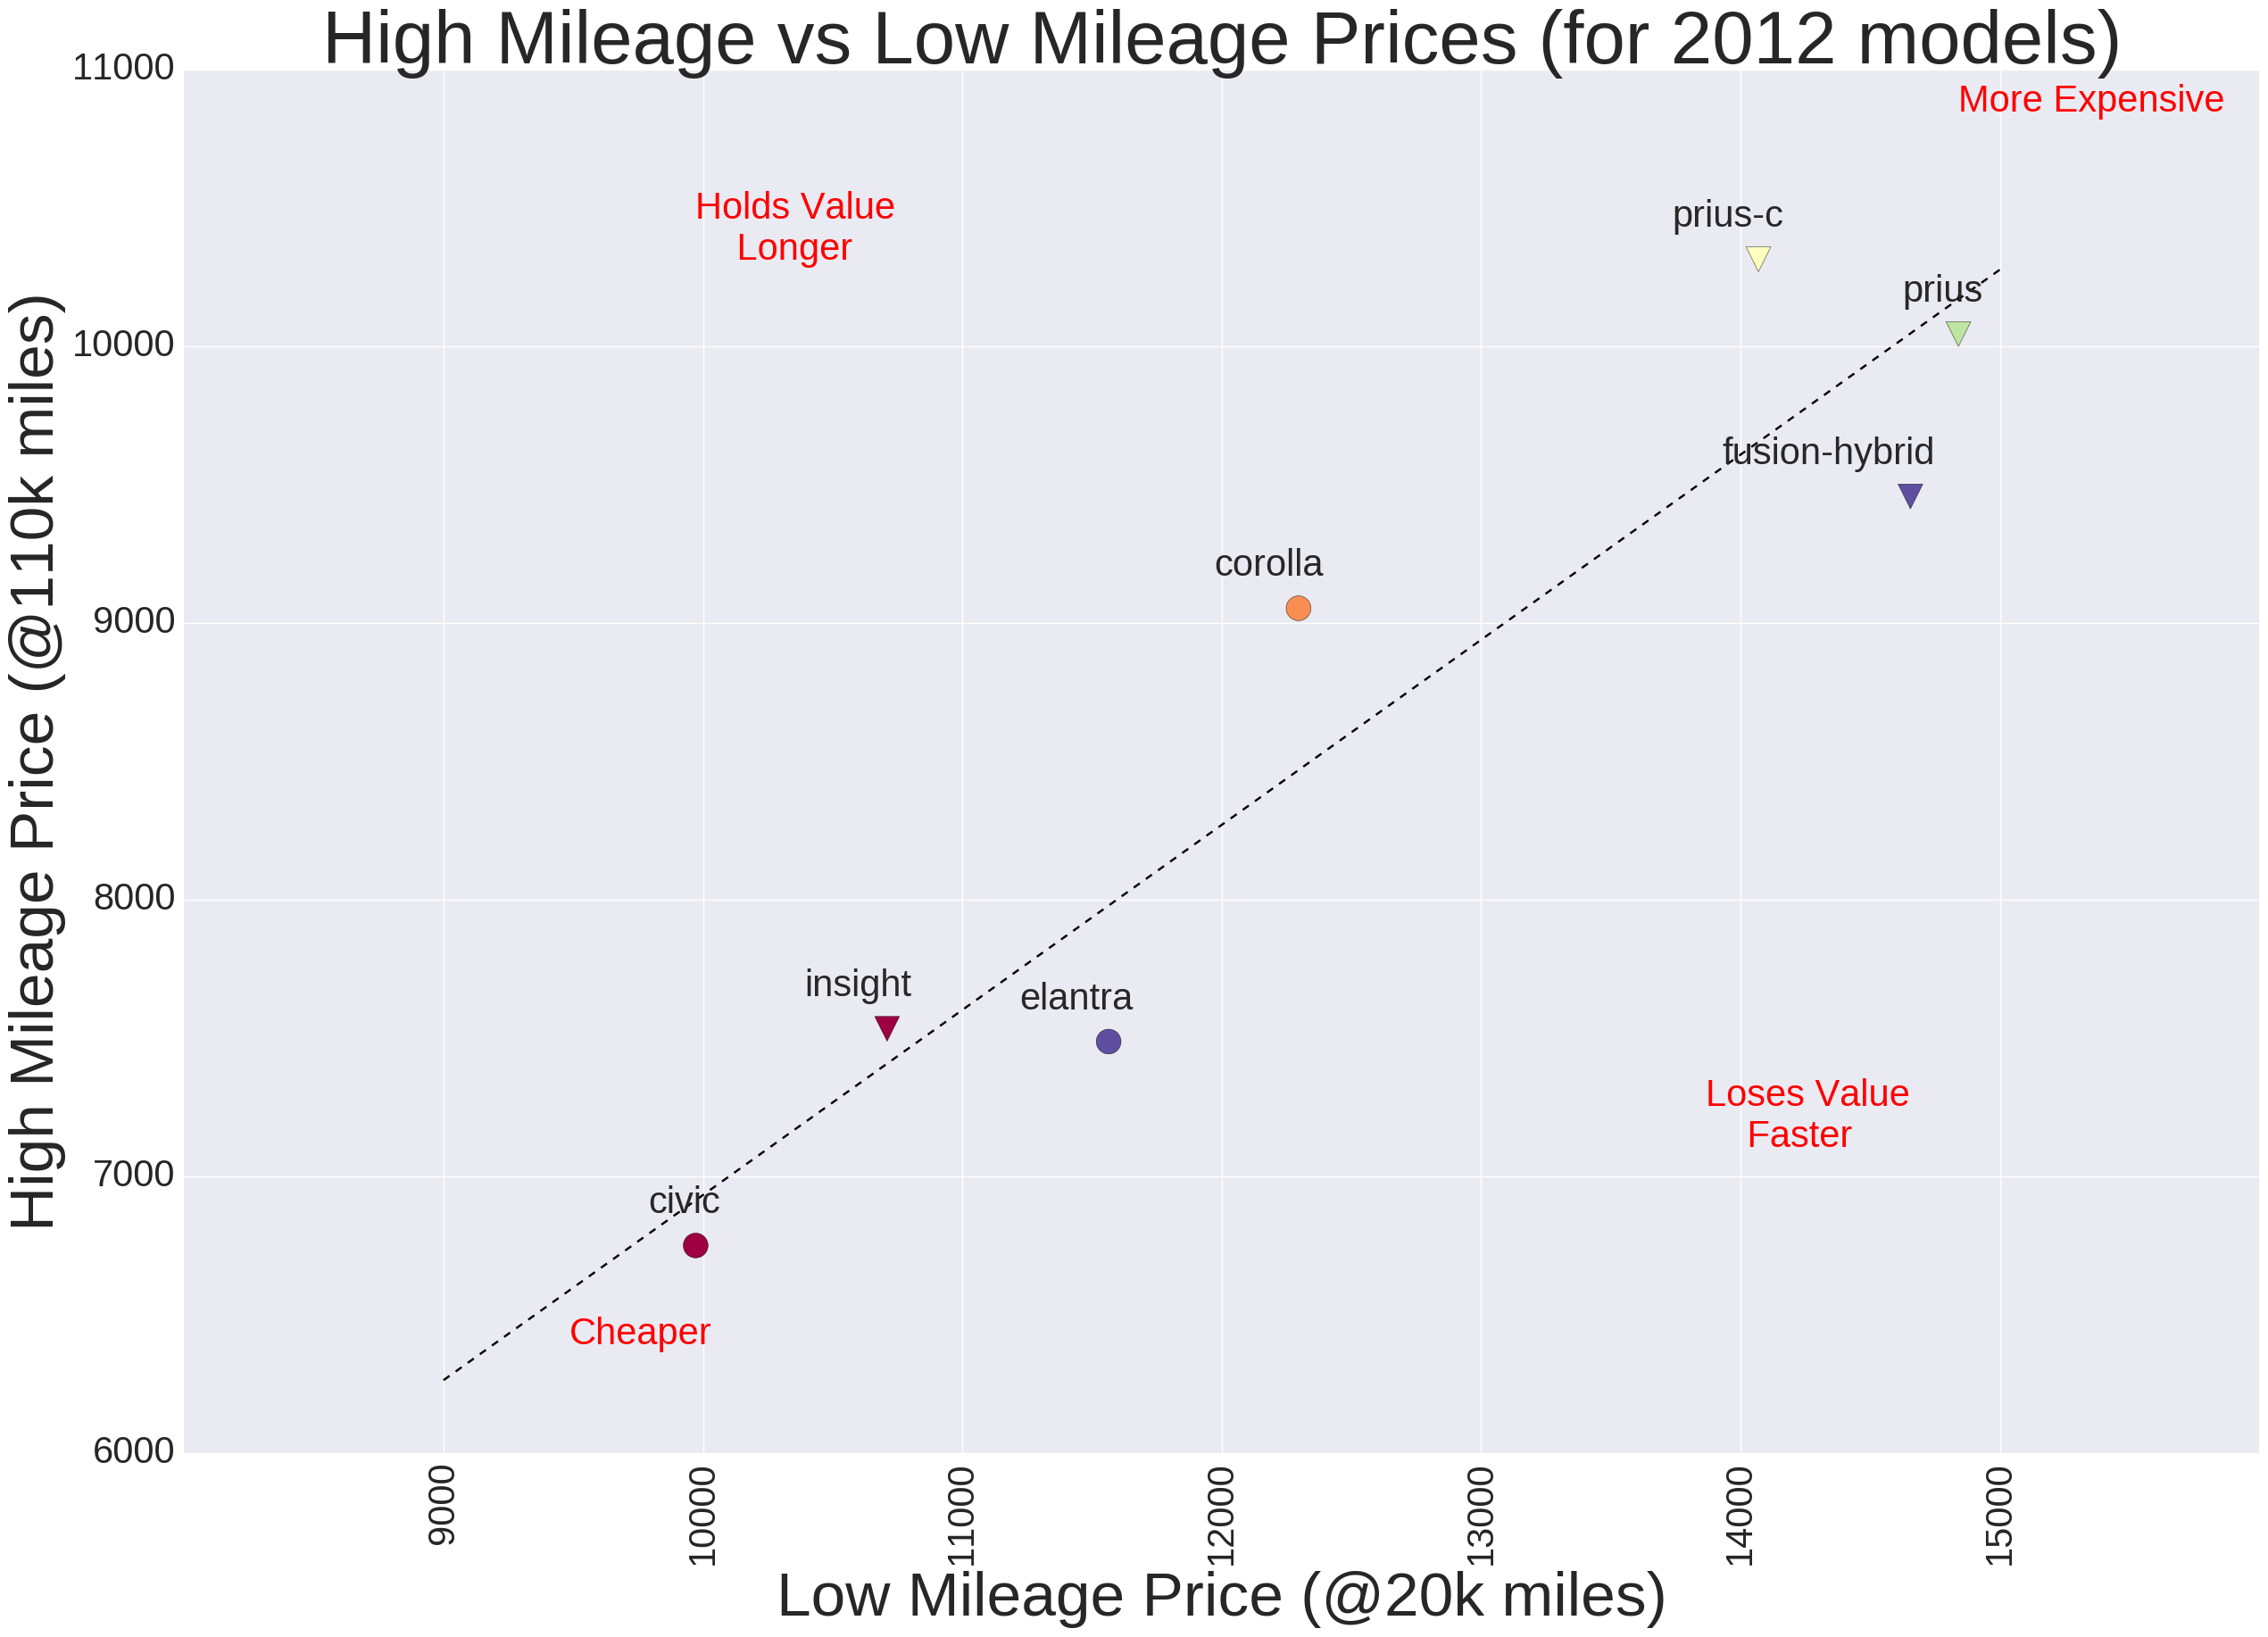

In [3]:
# make separate plots for each car model of the price trend vs mileage for all pricing options
for year in [2011, 2012]:
    fig, ax = plt.subplots()
    height = 20
    fig.set_figheight(height)
    width = 30
    fig.set_figwidth(width)
    ax.set_title('High Mileage vs Low Mileage Prices (for %d models)' % year, fontsize=width*2)
    ax.set_xlabel('Low Mileage Price (@20k miles)', fontsize=height*2.5)
    ax.set_ylabel('High Mileage Price (@110k miles)', fontsize=height*2.5)
    ax.tick_params(axis='y', labelsize=height*1.5)
    ax.tick_params(axis='x', labelsize=height*1.5)

    cars = df[df['year'] == year]['car'].unique()
    low_m_prices = df[(df['year'] == year) & (df['mileage'] == 20000)]['dealer'].values
    high_m_prices = df[(df['year'] == year) & (df['mileage'] == 110000)]['dealer'].values
    
    hybrid = [[], [], []]
    sedan = [[], [], []]
    
    for i, car, low, high in zip(range(len(cars)), cars, low_m_prices, high_m_prices):
        if car in ['insight', 'prius-c', 'fusion-hybrid', 'prius']:
            hybrid[0].append(low)
            hybrid[1].append(high)
            hybrid[2].append(i*1.0/len(cars))
        else:
            sedan[0].append(low)
            sedan[1].append(high)
            sedan[2].append(i*1.0/len(cars))
            
        plt.annotate(
                car, 
                xy = (low, high), xytext = (20, 20), fontsize=height*1.5, 
                textcoords = 'offset points', ha = 'right', va = 'bottom')
    
    plt.scatter(
        hybrid[0], 
        hybrid[1], 
        marker='v', 
        c=hybrid[2],
        s=height*20,
        cmap=plt.get_cmap('Spectral'))
    plt.scatter(
        sedan[0], 
        sedan[1], 
        marker='o', 
        c=sedan[2],
        s=height*20,
        cmap=plt.get_cmap('Spectral'))
    
    x_points = np.arange(1000*np.floor(low_m_prices.min()/1000), 
                            1000*np.ceil(low_m_prices.max()/1000)+1000, 1000)
    y_points = np.arange(1000*np.floor(high_m_prices.min()/1000), 
                            1000*np.ceil(high_m_prices.max()/1000)+1000, 1000)
    
    m, b = np.polyfit(low_m_prices,
                      high_m_prices, 1)
    plt.plot(x_points,
             x_points*m+b,
             c='k',
             linestyle='dashed')
        

    ax.set_yticks(y_points)
    plt.xticks(x_points, 
               range(int(1000*np.floor(low_m_prices.min()/1000)), 
                     int(1000*np.ceil(low_m_prices.max()/1000)+1000), 1000),
              rotation='vertical')
    
    x_min = low_m_prices.min()
    x_max = low_m_prices.max()
    dlt_x = x_max - x_min
    y_min = high_m_prices.min()
    y_max = high_m_prices.max()
    dlt_y = y_max - y_min
    
    plt.annotate('Loses Value\n    Faster', 
                 xy=(x_min+0.8*dlt_x, y_max-0.9*dlt_y),
                 color='r',
                 fontsize=height*1.5)
    plt.annotate('Holds Value\n    Longer', 
                 xy=(x_min, y_max),
                 color='r',
                 fontsize=height*1.5)
    plt.annotate('More Expensive', 
                 xy=(x_max+0*dlt_x, y_max+.15*dlt_y),
                 color='r',
                 fontsize=height*1.5)
    plt.annotate('Cheaper', 
                 xy=(x_min-.1*dlt_x, y_min-.1*dlt_y),
                 color='r',
                 fontsize=height*1.5)

    plt.show()


### 3. What mileage of car gives the best value?

There's a lot of factors to account for if you want to compare value in detail between different cars - initial purchase price, resale value, maintenance costs, gas mileage, reliability compared to other cars - the list goes on. In my first pass, however, I didn't have all of this information. We'll save a more detailed analysis for another day because we can still gain some insight with

The question I CAN answer is how does value change with mileage if you plan to keep the car until it dies. Should you spend more for a low mileage car, or save some money and buy a car with higher mileage? Which gives you the best bang for the buck in the long run? 

If we limit ourselves to one car at a time

#### 

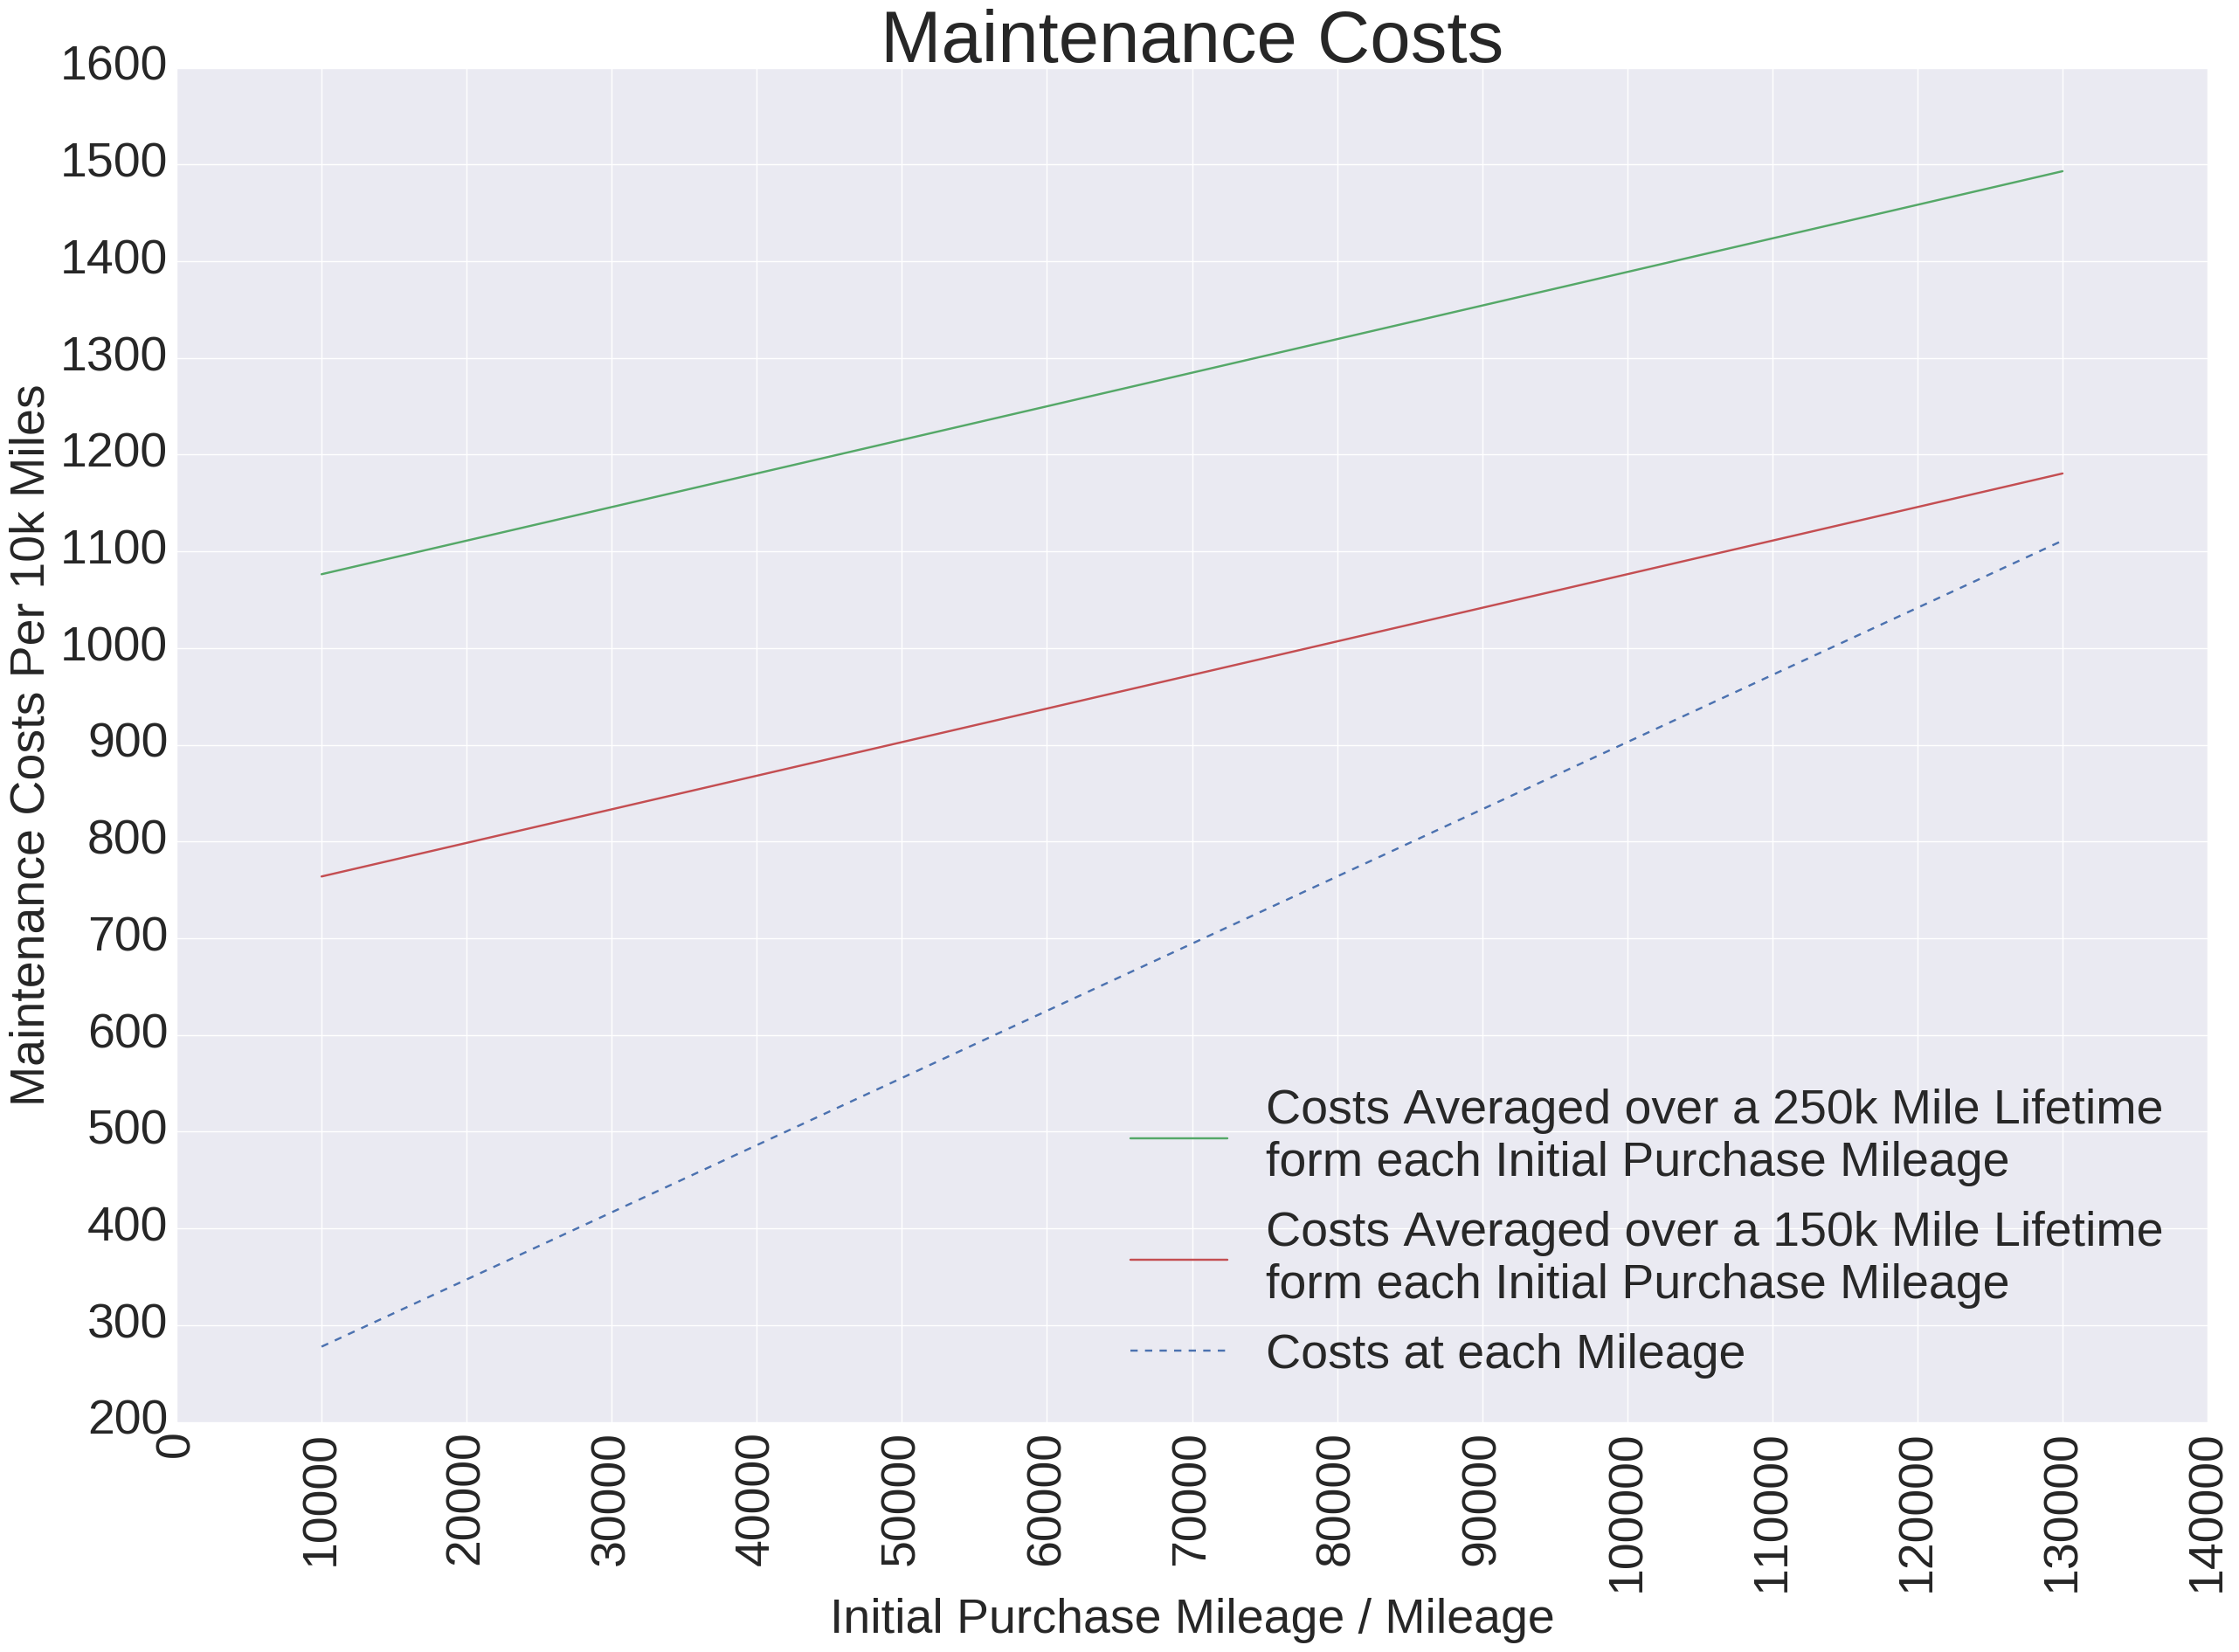

In [58]:
avg_miles_per_year = 12000.

maint_per_year_year0 = 200.
maint_per_year_year20 = 2000.

maint_per_mile_year0 = maint_per_year_year0 / avg_miles_per_year
maint_per_mile_year20 = maint_per_year_year20 / avg_miles_per_year

maintpermile_vs_miles_m = (maint_per_mile_year20 - maint_per_mile_year0) / (20.*avg_miles_per_year - 0.)
maintpermile_vs_miles_b = maint_per_mile_year0

def get_avg_maint_cost_per10k(start_mileage, end_mileage):
    if end_mileage > 240000:
        end_mileage = 240000
    
    avg_maint_cpm = maintpermile_vs_miles_b + \
                    maintpermile_vs_miles_m*(start_mileage+end_mileage)/2.
    
    return 10000*avg_maint_cpm

fig, ax = plt.subplots()
height = 20
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 40

ax.set_title('Maintenance Costs', fontsize=textheight*1.5)
ax.set_xlabel('Initial Purchase Mileage / Mileage', fontsize=textheight)
ax.set_ylabel('Maintenance Costs Per 10k Miles', fontsize=textheight)
ax.tick_params(axis='y', labelsize=textheight)
ax.tick_params(axis='x', labelsize=textheight)
ax.ticklabel_format()

total_maint_cost_per10k = []
total_maint_cost_per10k2 = []
maint_cost_per10k = []
for miles in subset[car][year].iterrows():
    total_maint_cost_per10k.append(get_avg_maint_cost_per10k(miles[1].mileage, 250000))
    total_maint_cost_per10k2.append(get_avg_maint_cost_per10k(miles[1].mileage, 150000))
    maint_cost_per10k.append(10000*(miles[1].mileage*maintpermile_vs_miles_m + maintpermile_vs_miles_b))

maint = ax.plot(subset[car][year].mileage, maint_cost_per10k, linestyle='dashed')
total = ax.plot(subset[car][year].mileage, total_maint_cost_per10k)
total2 = ax.plot(subset[car][year].mileage, total_maint_cost_per10k2)

ax.legend([total[0], 
           total2[0],
            maint[0]], 
            ['Costs Averaged over a %dk Mile Lifetime\nform each Initial Purchase Mileage'%(250), 
             'Costs Averaged over a %dk Mile Lifetime\nform each Initial Purchase Mileage'%(150), 
            'Costs at each Mileage'],
            fontsize=textheight,
            loc=0)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+100, 100))
plt.xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1]+10000, 10000), 
           range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])+10000, 10000),
          rotation='vertical')
        
plt.show()

787.071428571 763.888888889
841.076923077 798.611111111
888.833333333 833.333333333
940.090909091 868.055555556
1003.1 902.777777778
1078.55555556 937.5
1172.0 972.222222222
1291.71428571 1006.94444444
1451.5 1041.66666667
1677.4 1076.38888889
2022.0 1111.11111111
2605.0 1145.83333333
3786.0 1180.55555556
683.357142857 763.888888889
726.769230769 798.611111111
763.416666667 833.333333333
801.545454545 868.055555556
848.9 902.777777778
905.111111111 937.5
974.625 972.222222222
1063.42857143 1006.94444444
1181.5 1041.66666667
1350.4 1076.38888889
1609.25 1111.11111111
2050.0 1145.83333333
2947.0 1180.55555556
579.947368421 937.5
607.444444444 972.222222222
627.411764706 1006.94444444
646.3125 1041.66666667
668.733333333 1076.38888889
693.357142857 1111.11111111
721.230769231 1145.83333333
753.5 1180.55555556
791.727272727 1215.27777778
838.7 1250.0
898.666666667 1284.72222222
976.875 1319.44444444
1081.71428571 1354.16666667
503.526315789 937.5
524.888888889 972.222222222
538.882352941 1

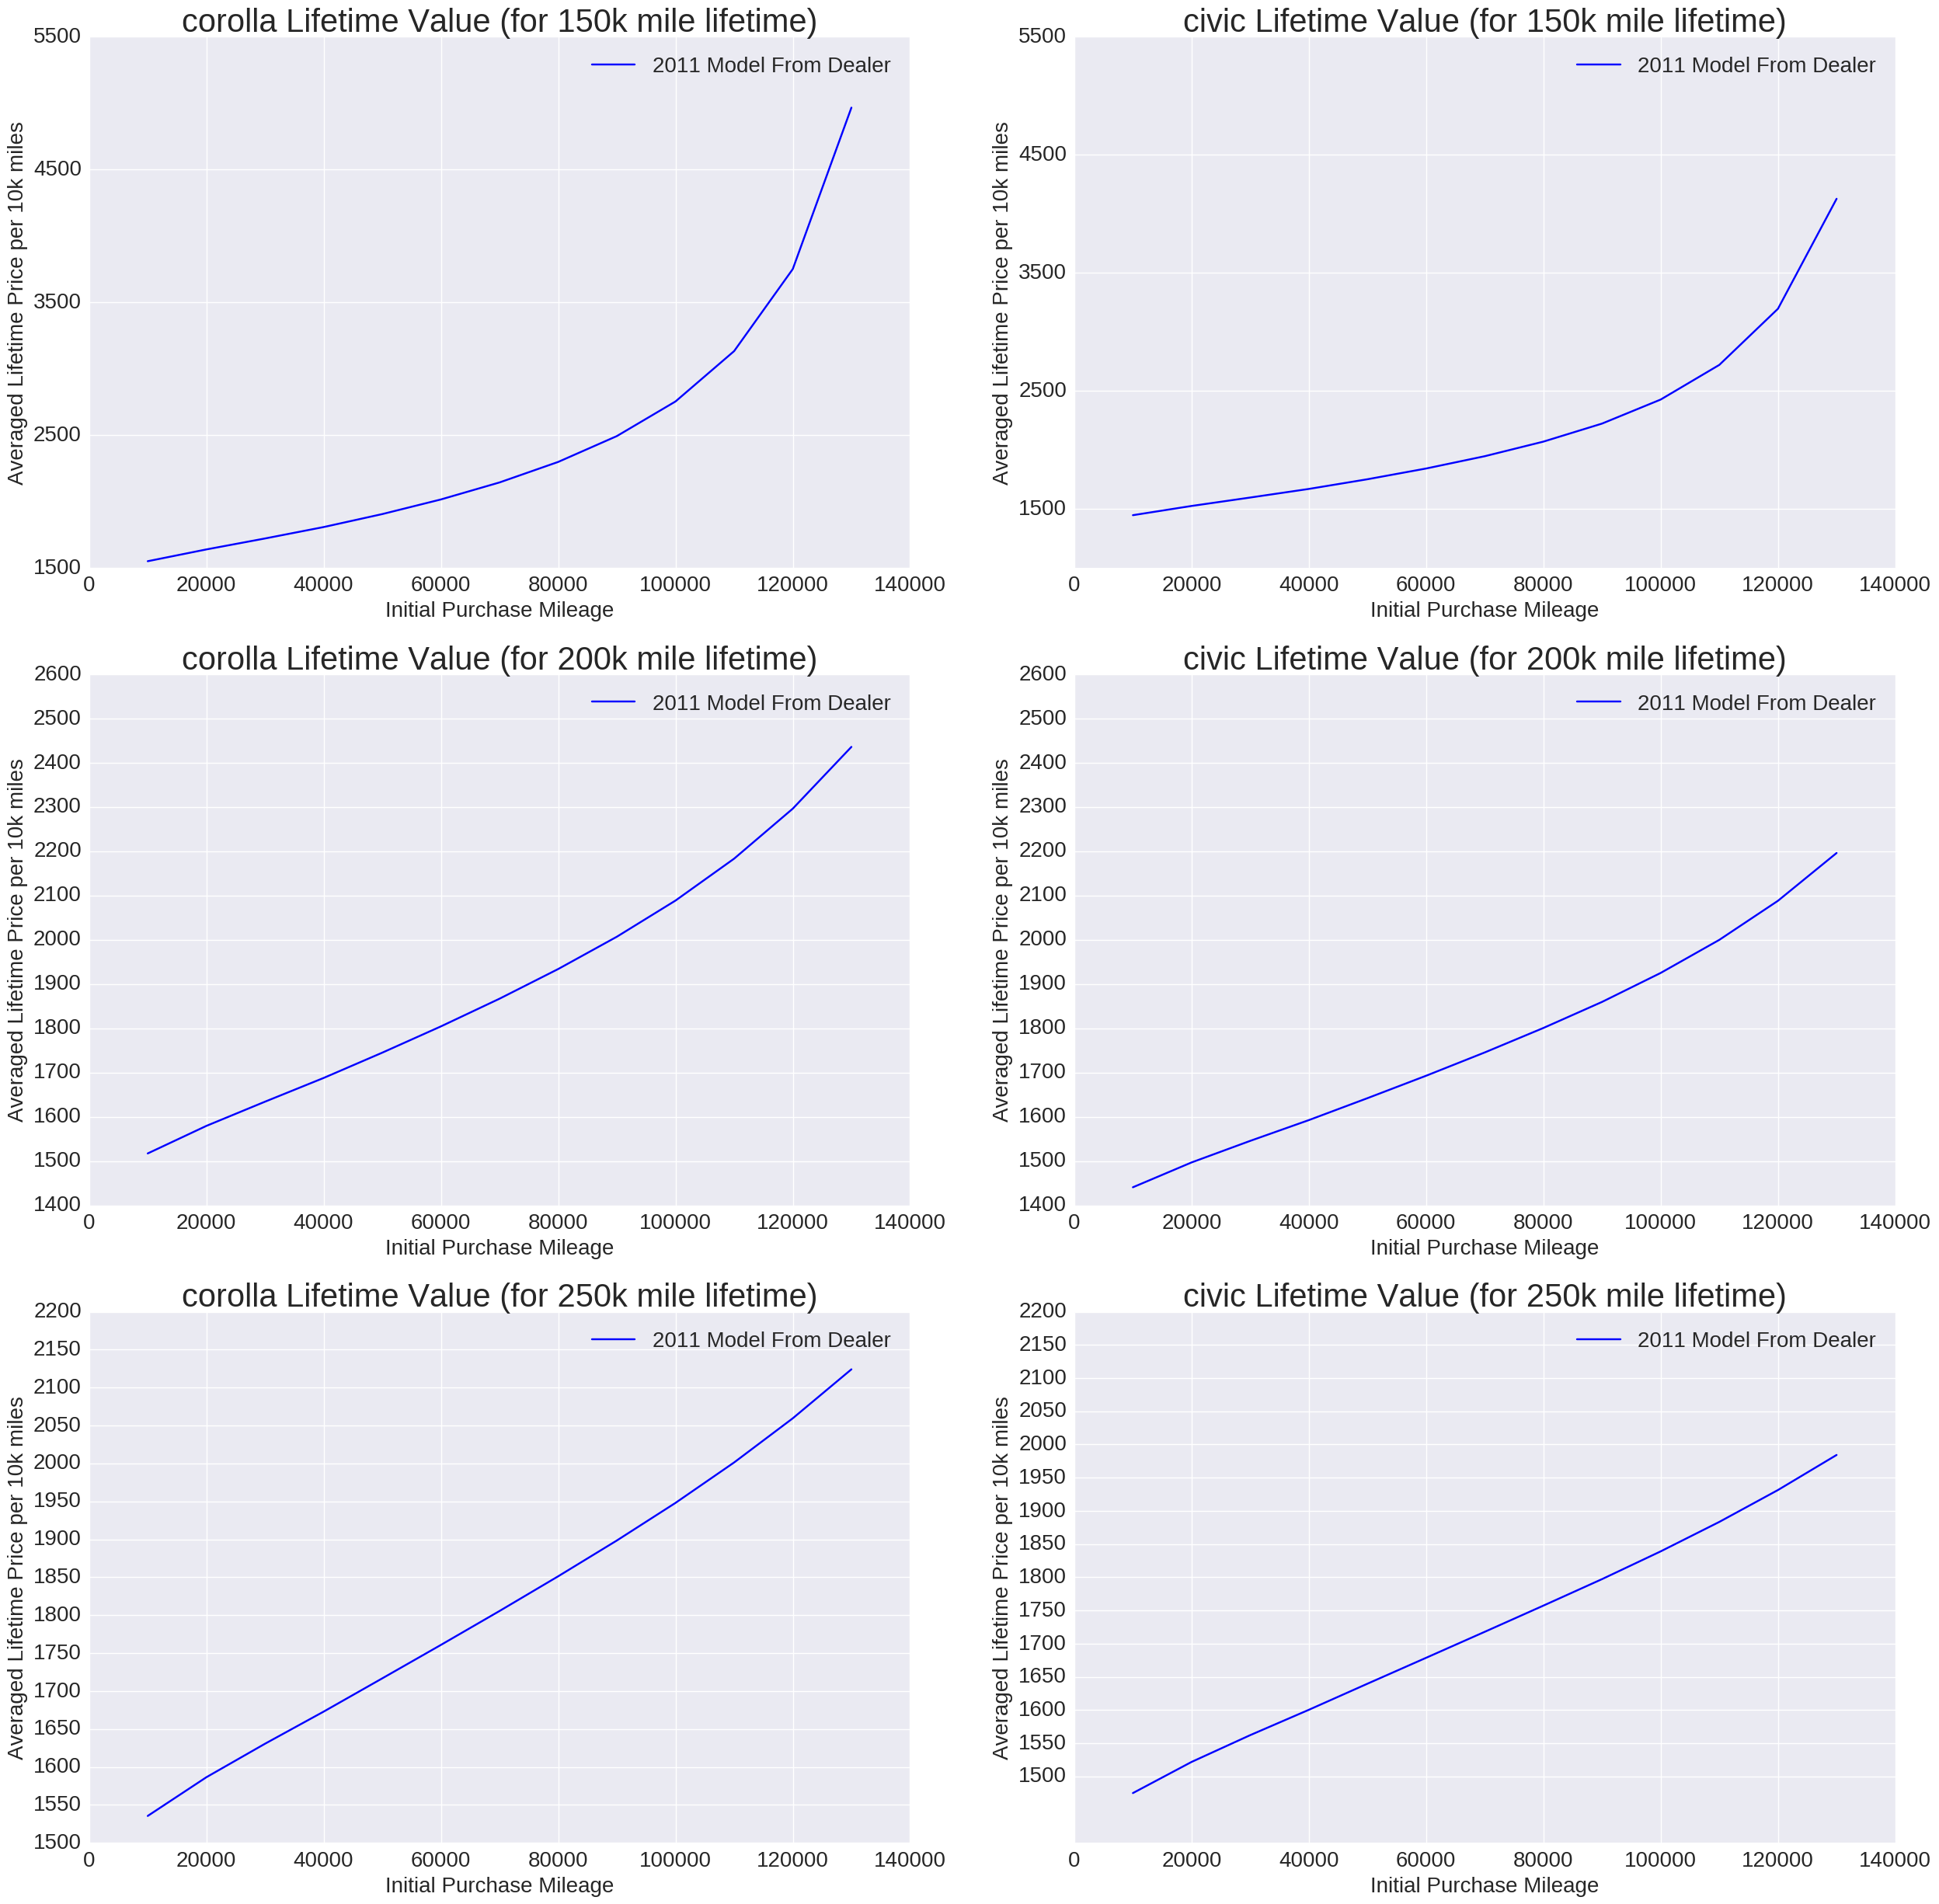

In [42]:
cars = ['corolla', 'civic']
lifetime_mileages = [150000, 200000, 250000]

fig, ax = plt.subplots(len(lifetime_mileages),len(cars))
height = 10*len(lifetime_mileages)
width = 15*len(cars)
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 20

year = 2011

for i, lifetime_mileage in enumerate(lifetime_mileages):
    for j, car in enumerate(cars):
        ax[i,j].set_title('%s Lifetime Value (for %dk mile lifetime)' % (car, lifetime_mileage/1000), fontsize=textheight*1.5)
        ax[i,j].set_xlabel('Initial Purchase Mileage', fontsize=textheight)
        ax[i,j].set_ylabel('Averaged Lifetime Price per 10k miles', fontsize=textheight)
        ax[i,j].tick_params(axis='y', labelsize=textheight)
        ax[i,j].tick_params(axis='x', labelsize=textheight)
        ax[i,j].ticklabel_format()

        price_cost_per10k = subset[car][year].dealer/(lifetime_mileage-subset[car][year].mileage)*10000
        maint_cost_per10k = get_avg_maint_cost_per10k(subset[car][year].mileage, lifetime_mileage)
        
        dealer = ax[i,j].plot(subset[car][year].mileage, 
                               price_cost_per10k+maint_cost_per10k, 
                               c='b')


        ax[i,j].legend([dealer[0]], 
                   ['2011 Model From Dealer'],
                  fontsize=textheight,
                  loc=0)

        if i == 0:
            y_incriment = 1000
        elif i == 1:
            y_incriment = 100
        else:
            y_incriment = 50
        
        if j == 0:
            y_min = ax[i,j].get_yticks()[0]
            y_max = ax[i,j].get_yticks()[-1]
        
        ax[i,j].set_yticks(np.arange(y_min, y_max+y_incriment, y_incriment))
        
plt.show()

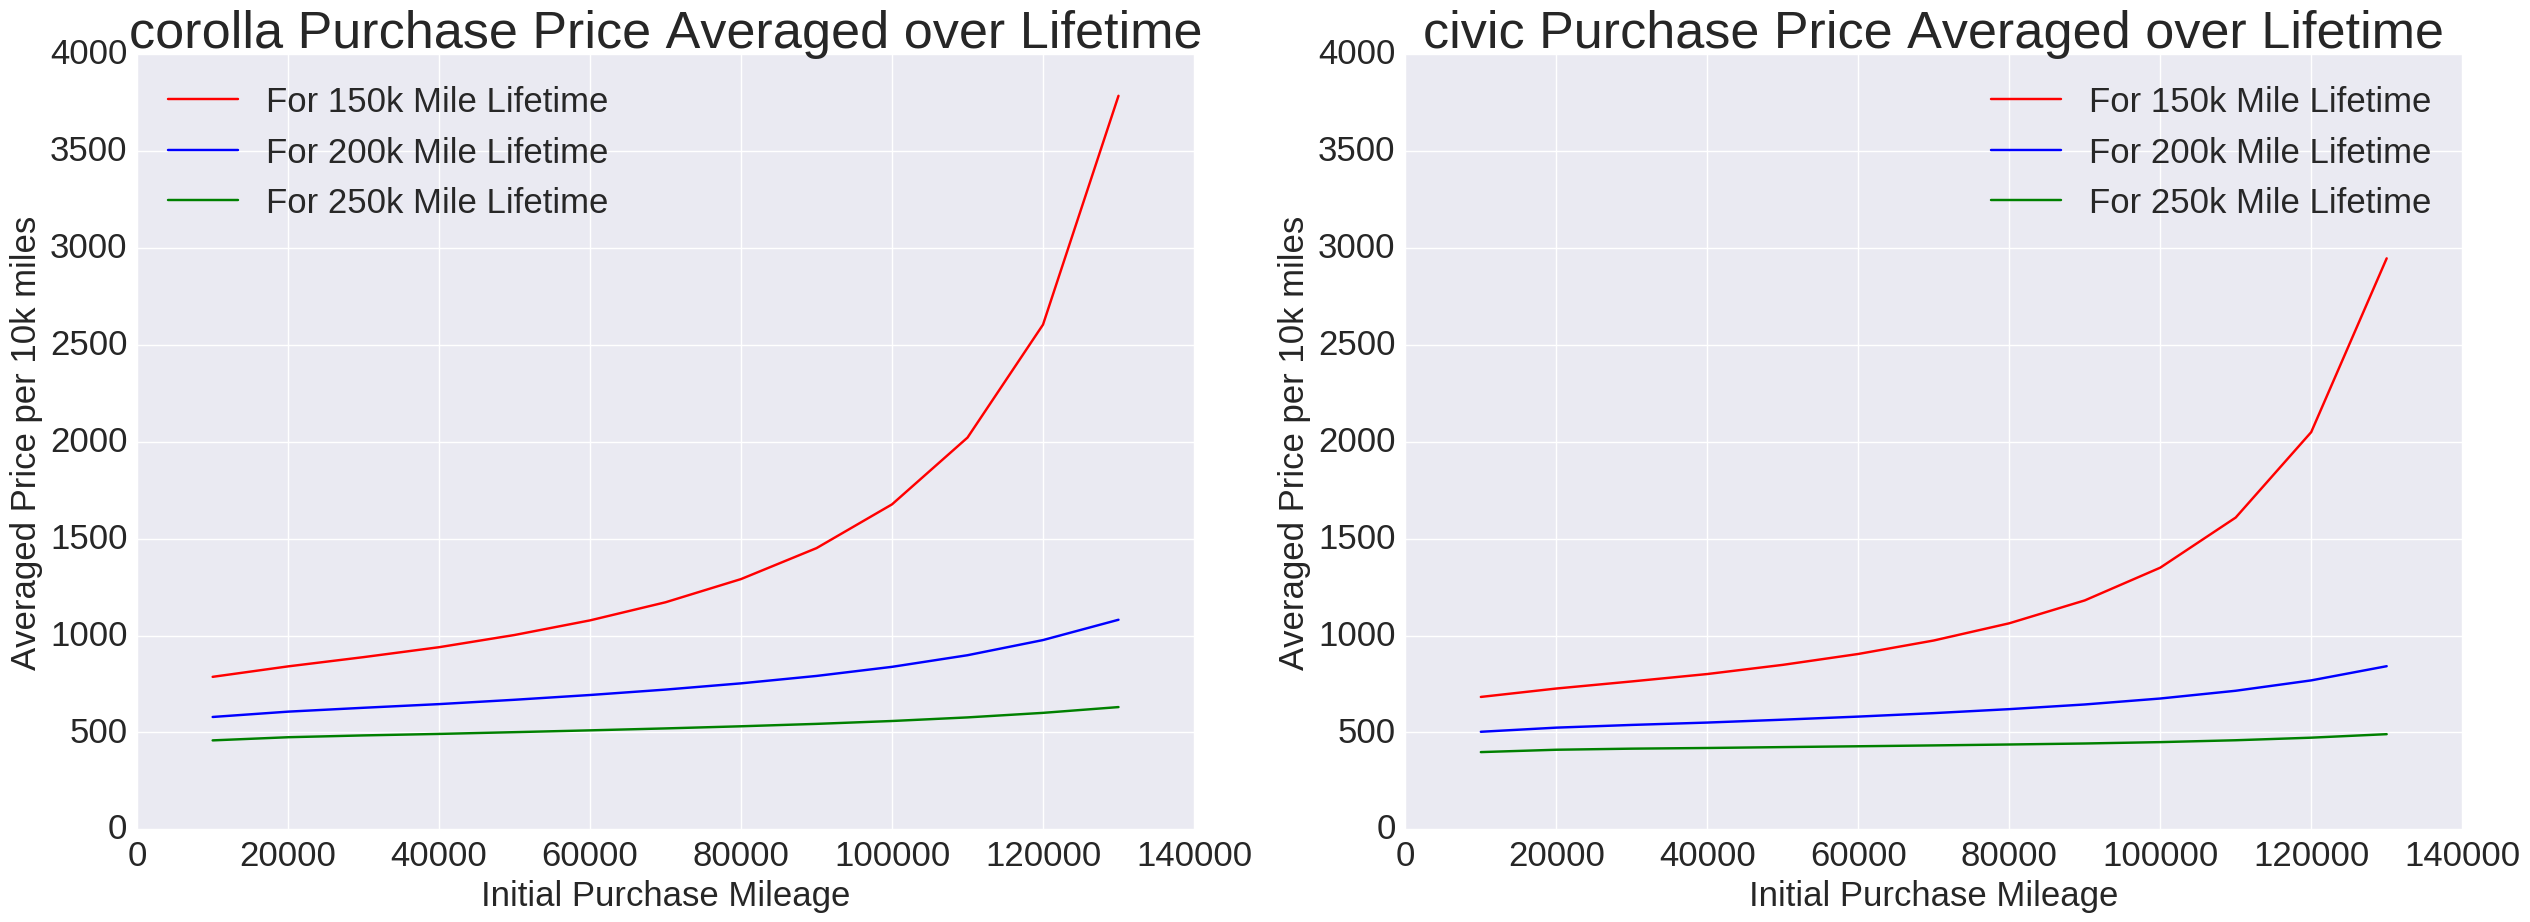

In [75]:
cars = ['corolla', 'civic']
lifetime_mileages = [150000, 200000, 250000]

fig, ax = plt.subplots(1,len(cars))
height = 10
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 25

year = 2011
colors = ['r', 'b', 'g']

for i, car in enumerate(cars):
    dealer = {}
    for j, lifetime_mileage in enumerate(lifetime_mileages):
        ax[i].set_title('%s Purchase Price Averaged over Lifetime' % (car), fontsize=textheight*1.5)
        ax[i].set_xlabel('Initial Purchase Mileage', fontsize=textheight)
        ax[i].set_ylabel('Averaged Price per 10k miles', fontsize=textheight)
        ax[i].tick_params(axis='y', labelsize=textheight)
        ax[i].tick_params(axis='x', labelsize=textheight)
        ax[i].ticklabel_format()

        price_cost_per10k = subset[car][year].dealer/(lifetime_mileage-subset[car][year].mileage)*10000
        maint_cost_per10k = get_avg_maint_cost_per10k(subset[car][year].mileage, lifetime_mileage)
        
        dealer[lifetime_mileage] = ax[i].plot(subset[car][year].mileage, 
                                               price_cost_per10k, 
                                               c=colors[j])


    ax[i].legend([dealer[miles][0] for miles in lifetime_mileages], 
               ['For %dk Mile Lifetime'%(miles/1000) for miles in lifetime_mileages],
              fontsize=textheight,
              loc=0)

    if i == 0:
        y_min = ax[i].get_yticks()[0]
        y_max = ax[i].get_yticks()[-1]
        
    y_incriment = 500
    ax[i].set_yticks(np.arange(y_min, y_max+y_incriment, y_incriment))
        
plt.show()

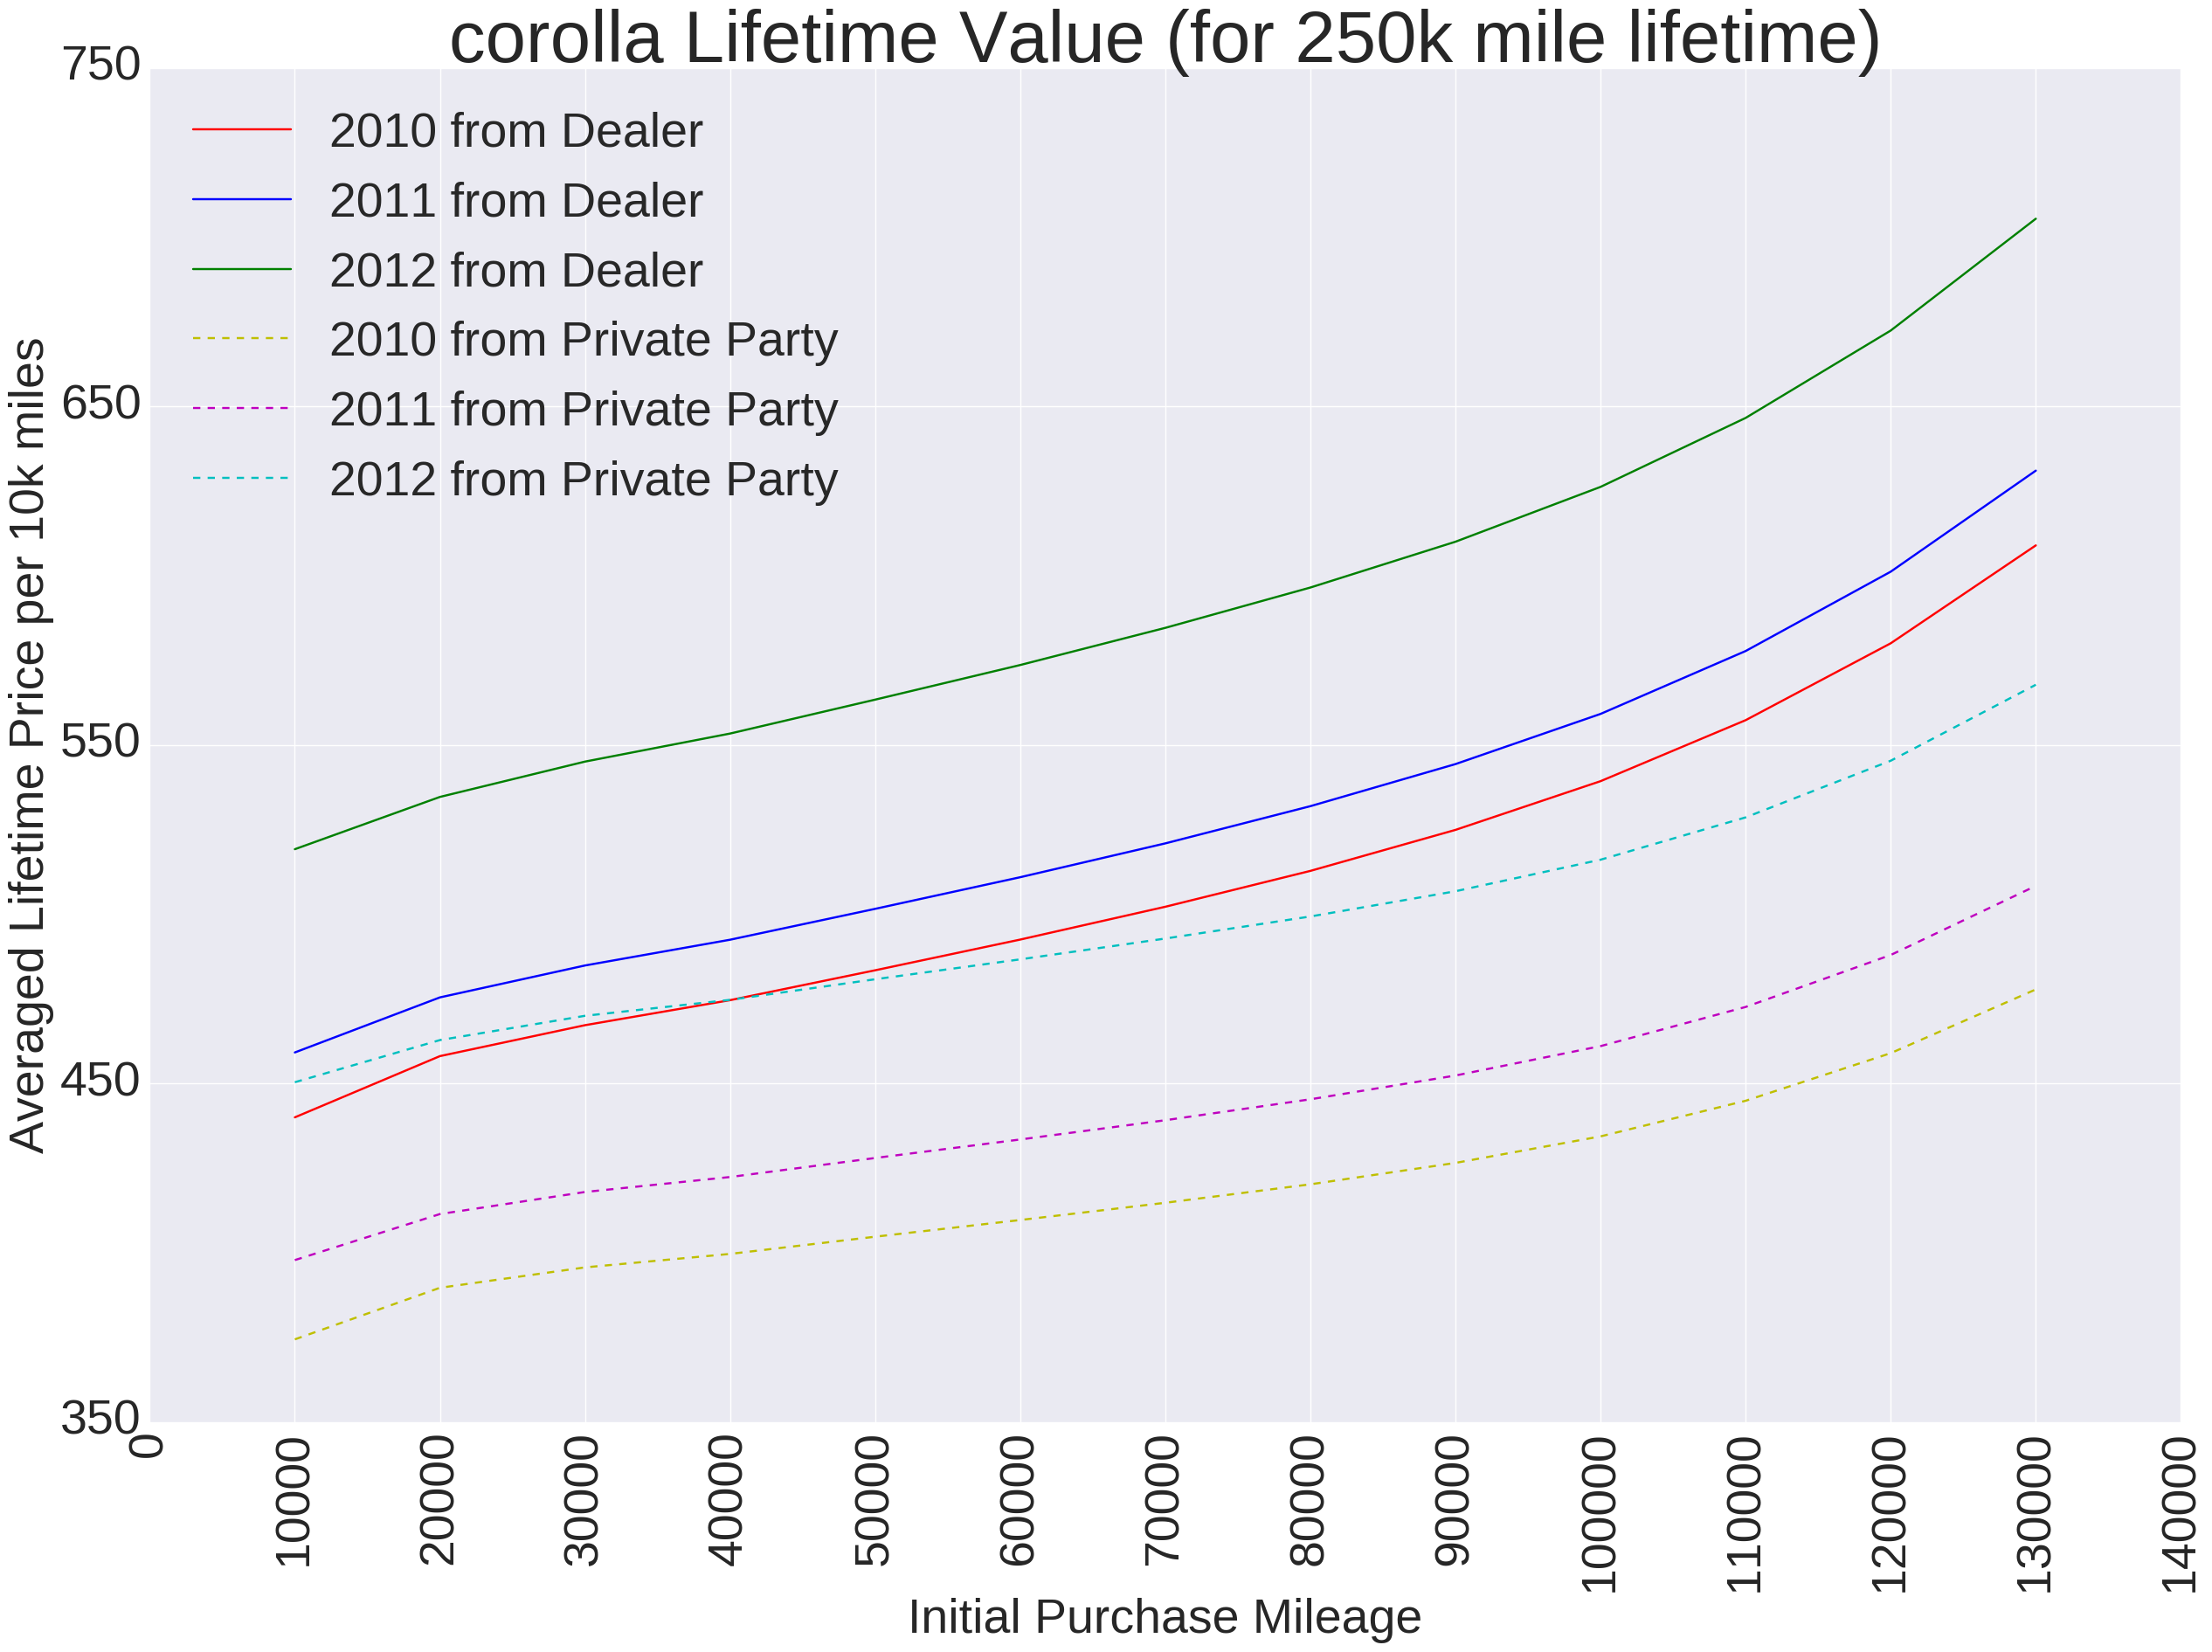

In [5]:
car = 'corolla'
lifetime_mileage = 250000

fig, ax = plt.subplots()
height = 20
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 40


ax.set_title('%s Lifetime Value (for %dk mile lifetime)' % (car, lifetime_mileage/1000), fontsize=textheight*1.5)
ax.set_xlabel('Initial Purchase Mileage', fontsize=textheight)
ax.set_ylabel('Averaged Lifetime Price per 10k miles', fontsize=textheight)
ax.tick_params(axis='y', labelsize=textheight)
ax.tick_params(axis='x', labelsize=textheight)
ax.ticklabel_format()

dealer = {}
private = {}
colors = {'dealer':{2010:'r', 2011:'b', 2012:'g'},
          'private':{2010:'y', 2011:'m', 2012:'c'}}

for year in [2010, 2011, 2012]:
    dealer[year] = ax.plot(subset[car][year].mileage, 
                           subset[car][year].dealer/(lifetime_mileage-subset[car][year].mileage)*10000, 
                           c=colors['dealer'][year])
    private[year] = ax.plot(subset[car][year].mileage, 
                            subset[car][year].pp_verygood/(lifetime_mileage-subset[car][year].mileage)*10000,
                            c=colors['private'][year],
                            linestyle='dashed')


ax.legend([dealer[2010][0], 
            dealer[2011][0], 
            dealer[2012][0],
            private[2010][0],
            private[2011][0],
            private[2012][0]], 
           ['2010 from Dealer', 
            '2011 from Dealer', 
            '2012 from Dealer',
            '2010 from Private Party',
            '2011 from Private Party',
            '2012 from Private Party'],
          fontsize=textheight,
          loc=0)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+100, 100))
plt.xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1]+10000, 10000), 
           range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])+10000, 10000),
          rotation='vertical')
        
plt.show()

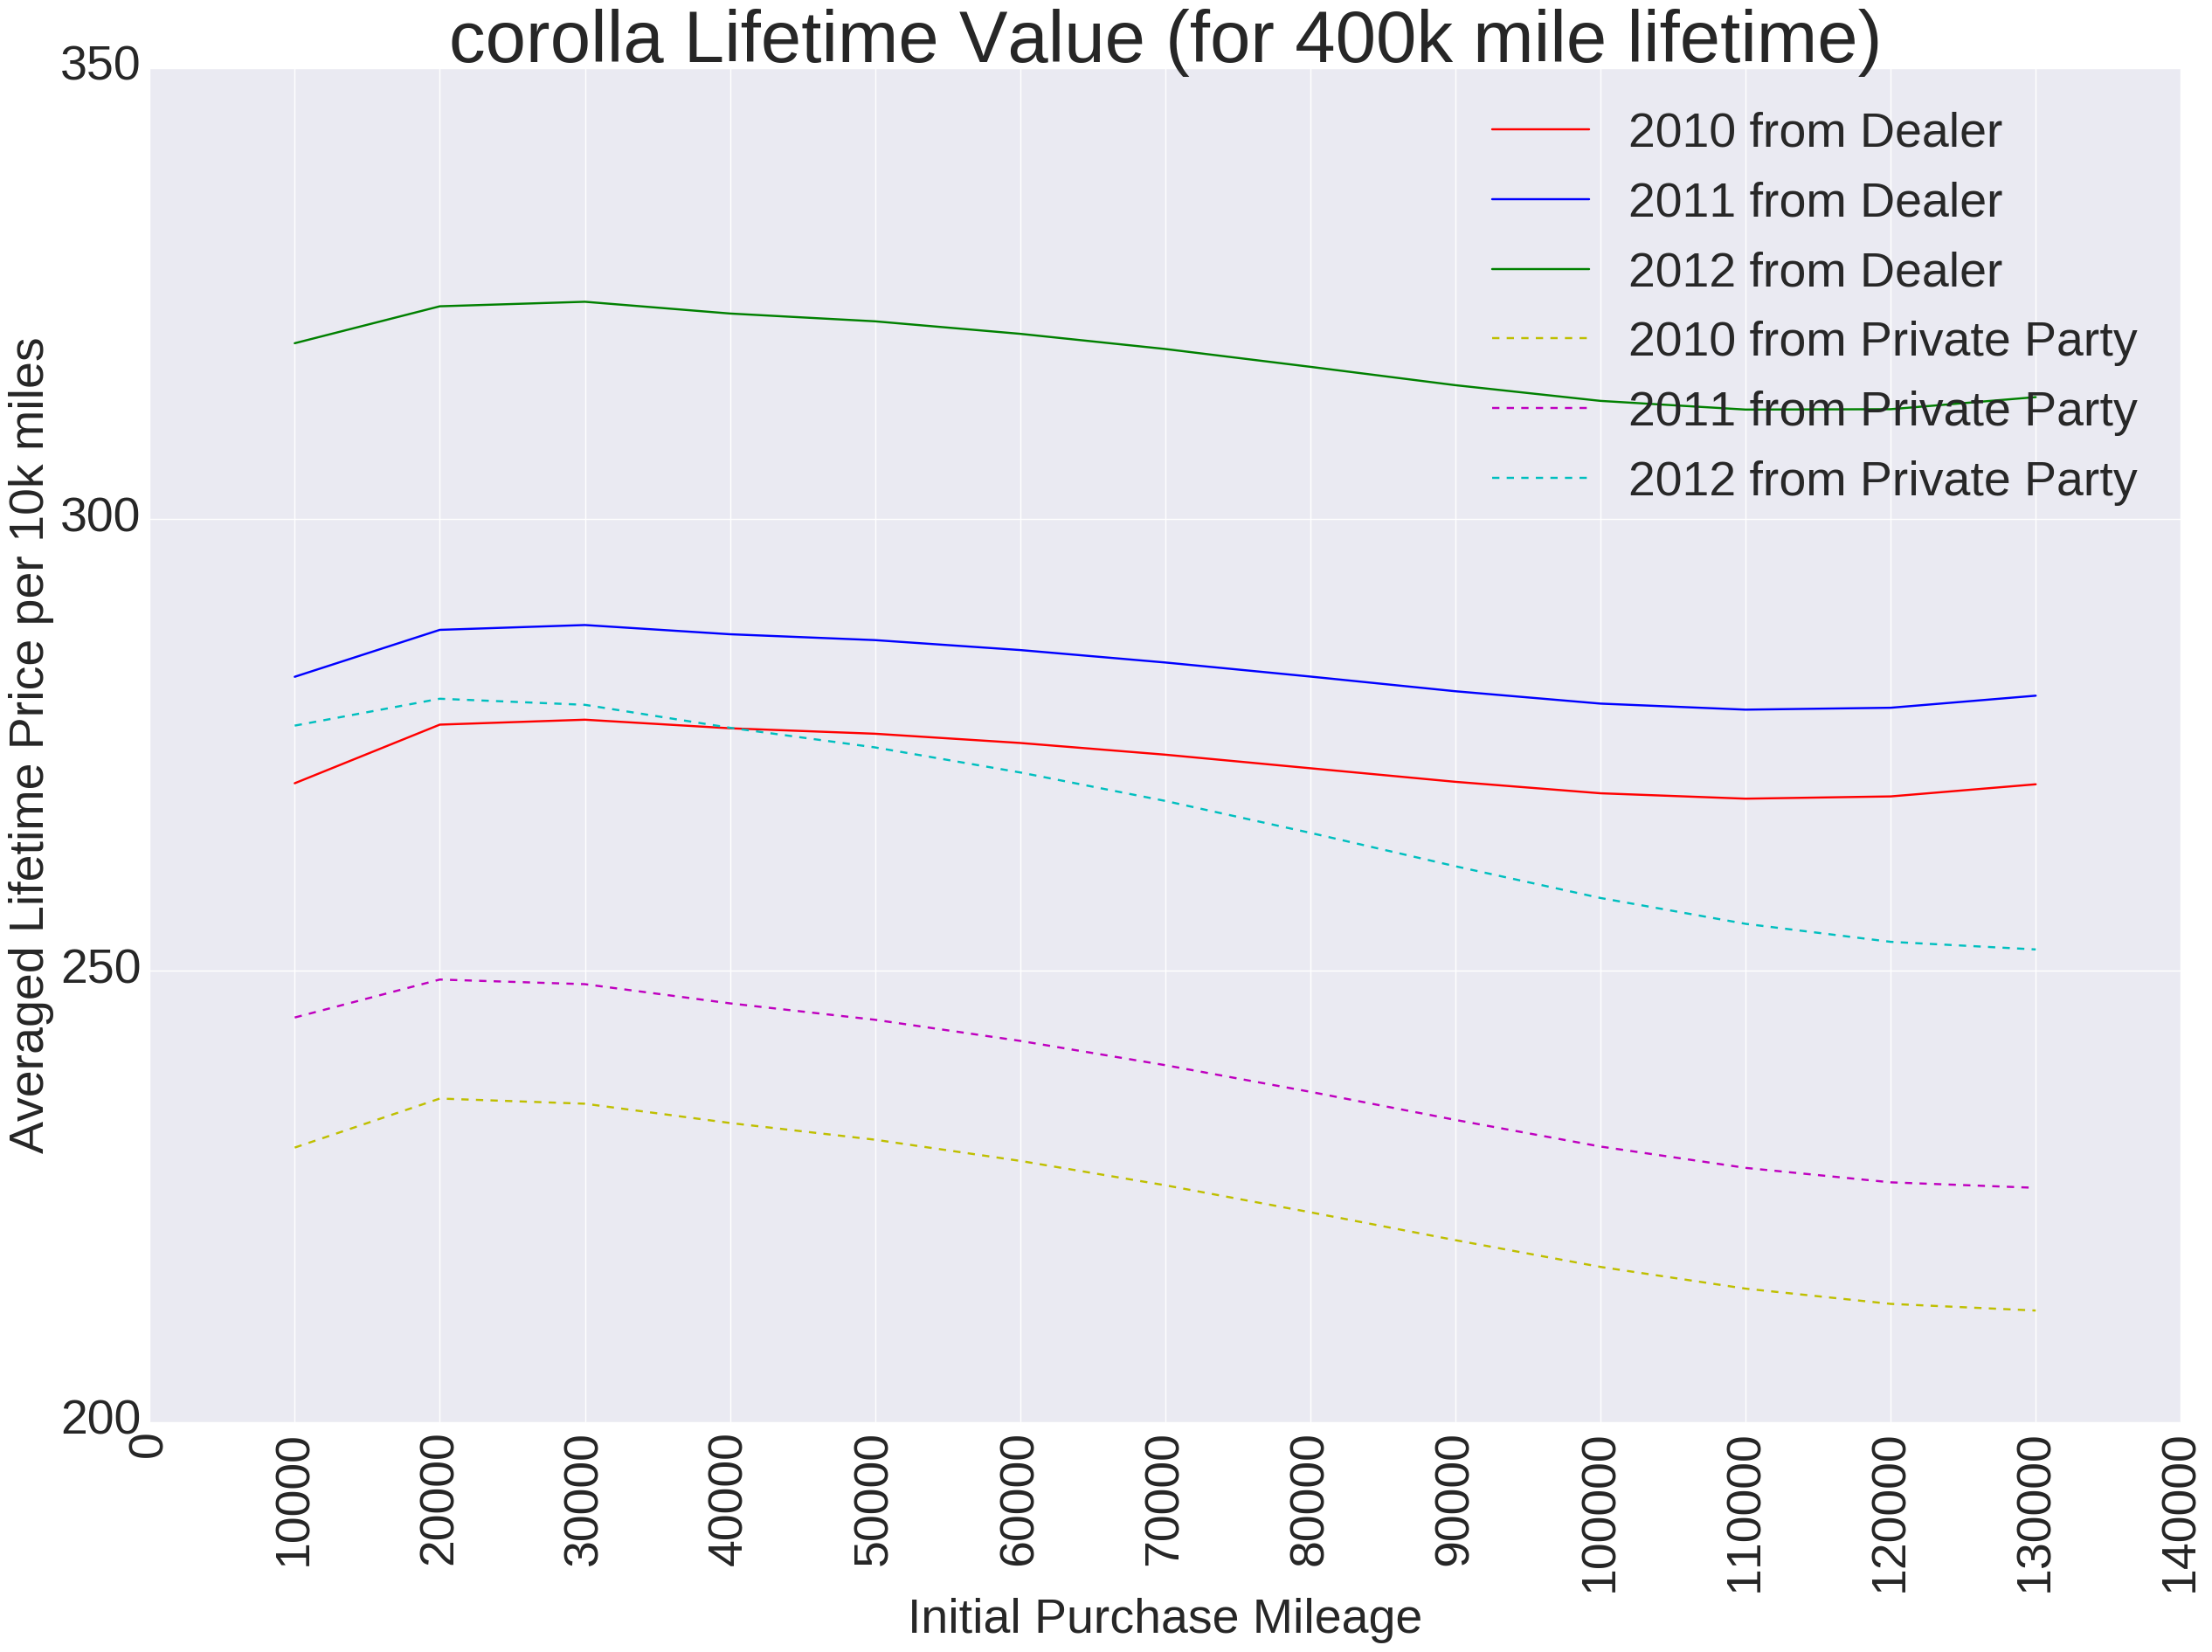

In [6]:
car = 'corolla'
lifetime_mileage = 400000

fig, ax = plt.subplots()
height = 20
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 40


ax.set_title('%s Lifetime Value (for %dk mile lifetime)' % (car, lifetime_mileage/1000), 
             fontsize=textheight*1.5)
ax.set_xlabel('Initial Purchase Mileage', fontsize=textheight)
ax.set_ylabel('Averaged Lifetime Price per 10k miles', fontsize=textheight)
ax.tick_params(axis='y', labelsize=textheight)
ax.tick_params(axis='x', labelsize=textheight)
ax.ticklabel_format()

dealer = {}
private = {}
colors = {'dealer':{2010:'r', 2011:'b', 2012:'g'},
          'private':{2010:'y', 2011:'m', 2012:'c'}}

for year in [2010, 2011, 2012]:
    dealer[year] = ax.plot(subset[car][year].mileage, 
                           subset[car][year].dealer/(lifetime_mileage-subset[car][year].mileage)*10000, 
                           c=colors['dealer'][year])
    private[year] = ax.plot(subset[car][year].mileage, 
                            subset[car][year].pp_verygood/(lifetime_mileage-subset[car][year].mileage)*10000,
                            c=colors['private'][year],
                            linestyle='dashed')


ax.legend([dealer[2010][0], 
            dealer[2011][0], 
            dealer[2012][0],
            private[2010][0],
            private[2011][0],
            private[2012][0]], 
           ['2010 from Dealer', 
            '2011 from Dealer', 
            '2012 from Dealer',
            '2010 from Private Party',
            '2011 from Private Party',
            '2012 from Private Party'],
          fontsize=textheight,
          loc=0)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+50, 50))
plt.xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1]+10000, 10000), 
           range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])+10000, 10000),
          rotation='vertical')
        
plt.show()

### 4. How does a hybrid compare in long term value compared to a standard sedan?



<img src="https://d3vl3jxeh4ou3u.cloudfront.net/Most%20and%20Least%203.png">

<img src="http://blog.iseecars.com/wp-content/uploads/2016/03/Screen-shot-2016-03-03-at-8.33.35-PM.png">

434.5 774.0 625.0
451.3 774.0 694.444444444
448.2 774.0 763.888888889
435.9 774.0 833.333333333
423.2 774.0 902.777777778
407.2 774.0 972.222222222
388.8 774.0 1041.66666667
368.4 774.0 1111.11111111
346.1 774.0 1180.55555556
323.9 774.0 1250.0
302.3 774.0 1319.44444444
281.7 774.0 1388.88888889
262.6 774.0 1458.33333333
512.6 546.75 625.0
529.1 546.75 694.444444444
526.1 546.75 763.888888889
514.1 546.75 833.333333333
501.6 546.75 902.777777778
485.9 546.75 972.222222222
467.9 546.75 1041.66666667
447.9 546.75 1111.11111111
426.1 546.75 1180.55555556
404.4 546.75 1250.0
383.2 546.75 1319.44444444
363.1 546.75 1388.88888889
344.5 546.75 1458.33333333
478.7 774.0 625.0
497.5 774.0 694.444444444
495.0 774.0 763.888888889
483.7 774.0 833.333333333
471.3 774.0 902.777777778
455.9 774.0 972.222222222
438.1 774.0 1041.66666667
418.4 774.0 1111.11111111
397.3 774.0 1180.55555556
375.6 774.0 1250.0
354.7 774.0 1319.44444444
334.8 774.0 1388.88888889
316.3 774.0 1458.33333333
662.1 450.0 625.0


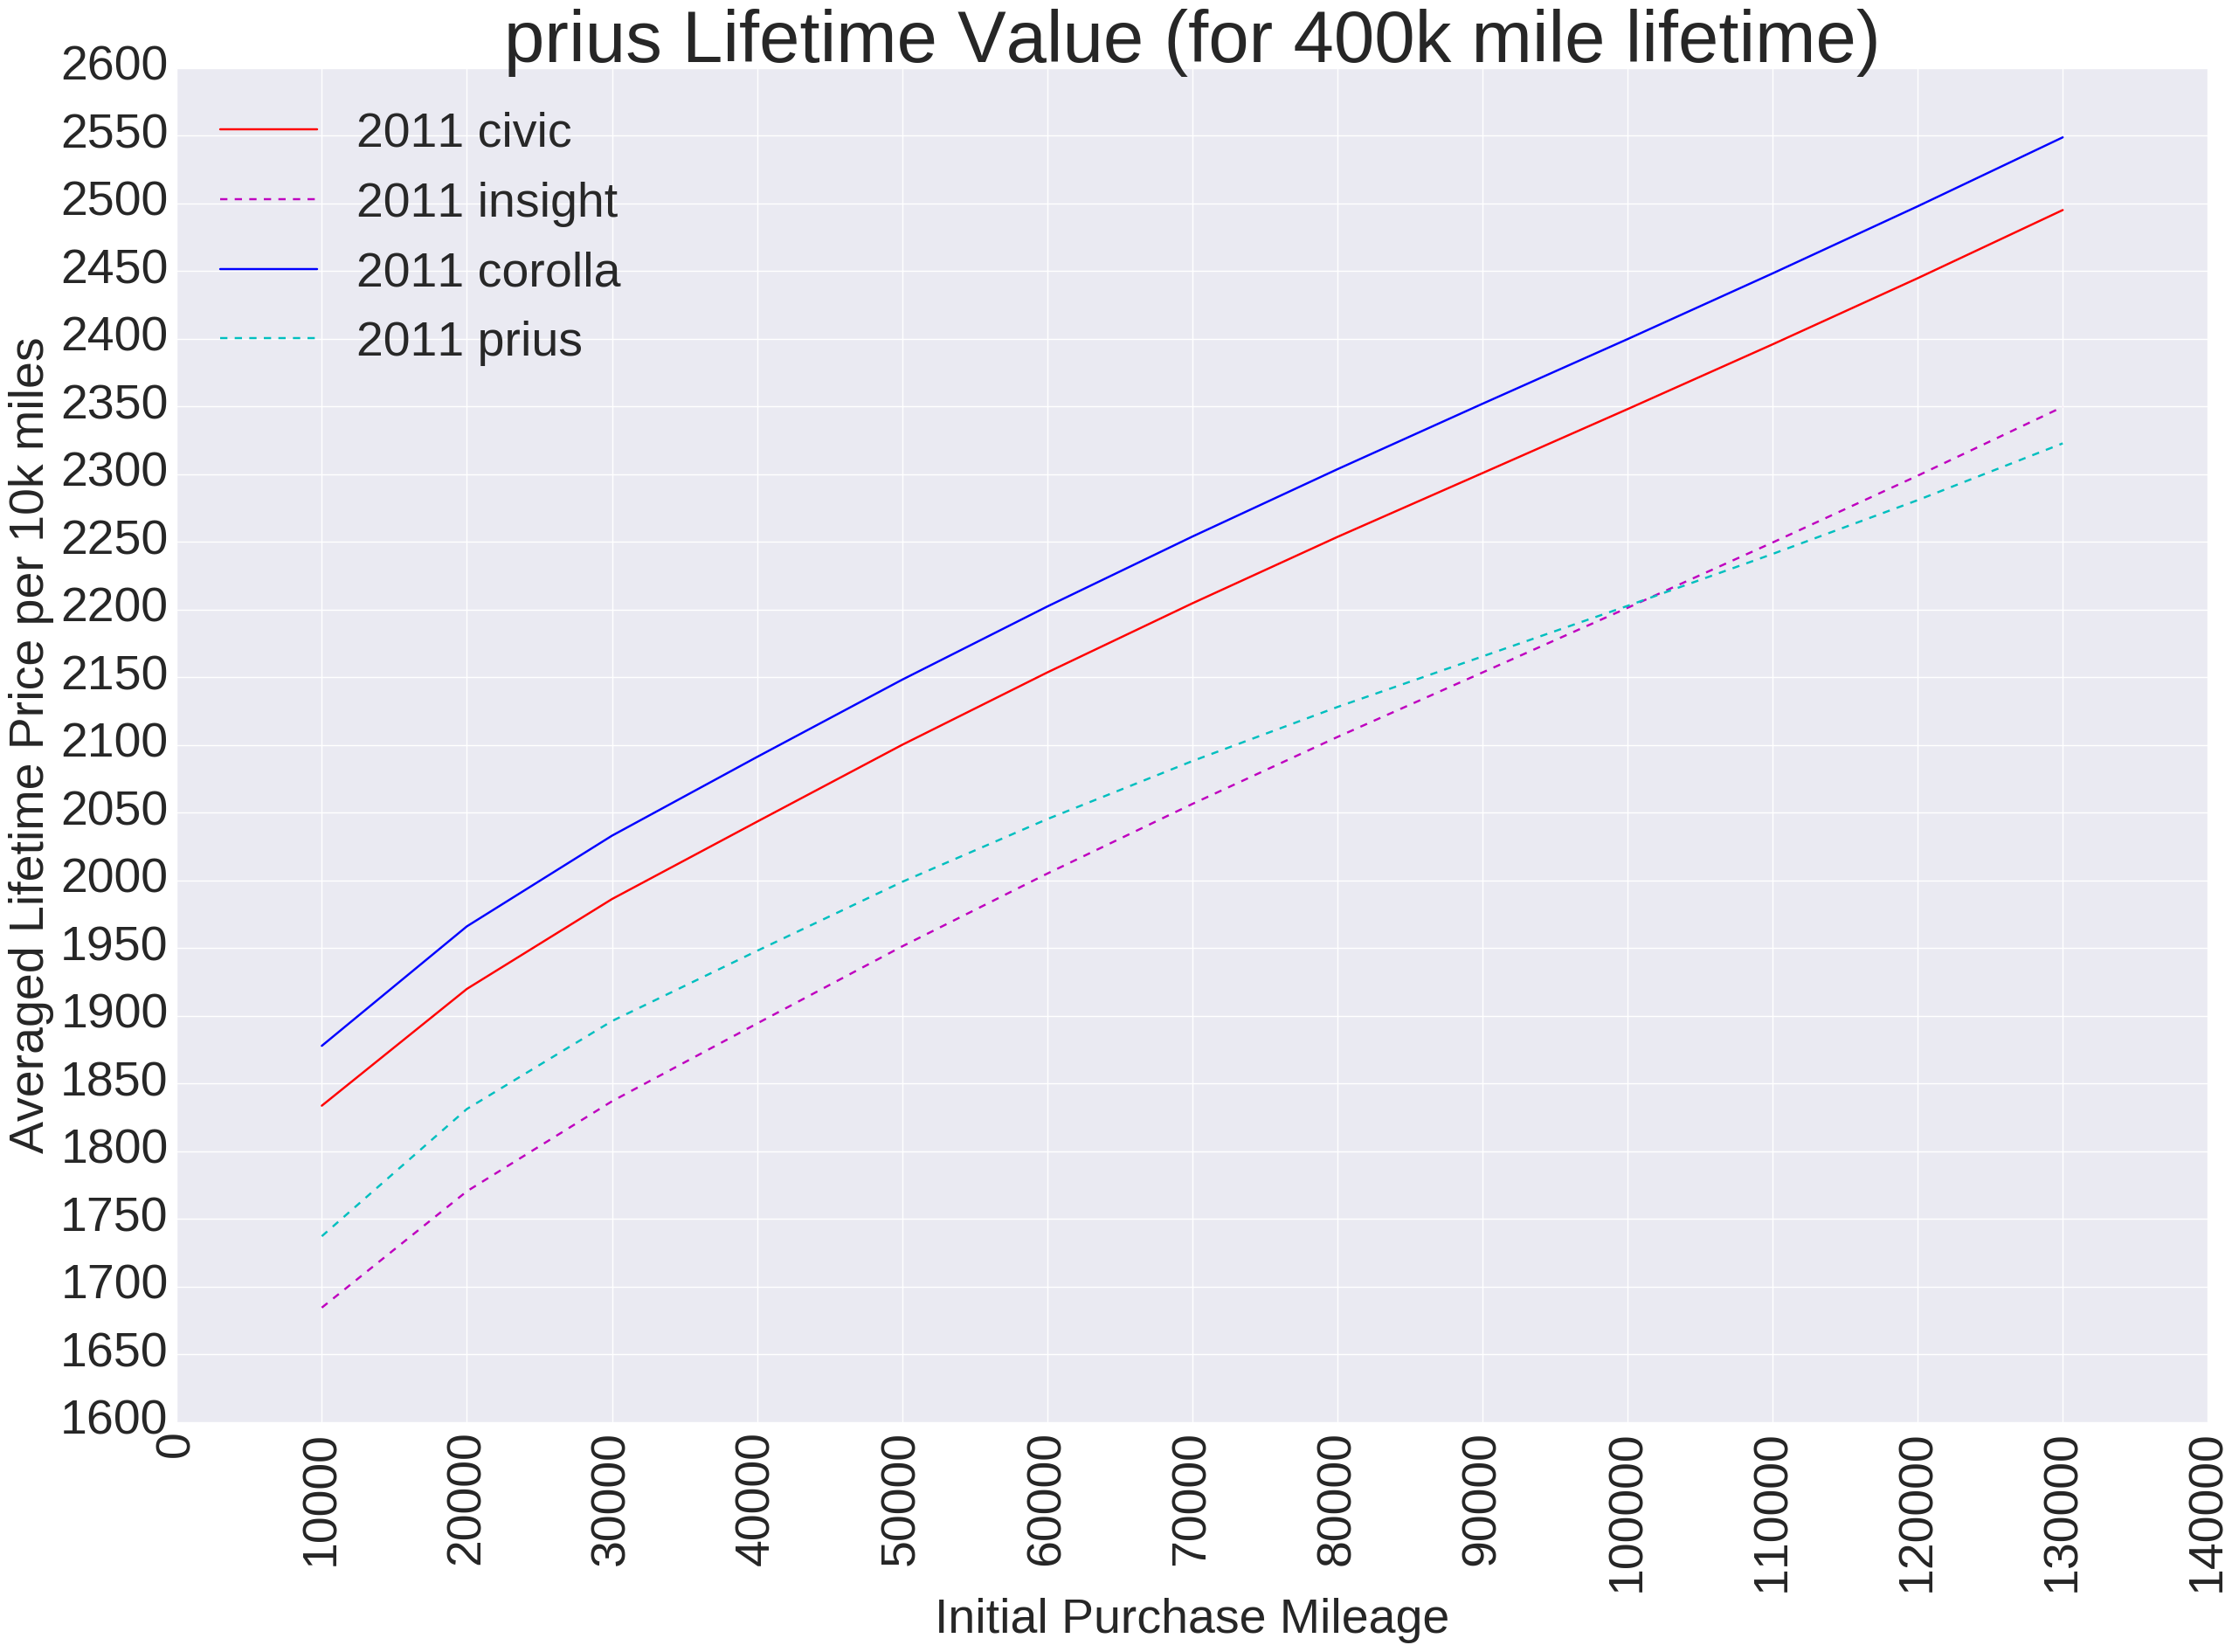

In [37]:
avg_miles_per_year = 12000.

maint_per_year_year0 = 250.
maint_per_year_year20 = 2250.

maint_per_mile_year0 = maint_per_year_year0 / avg_miles_per_year
maint_per_mile_year20 = maint_per_year_year20 / avg_miles_per_year

maintpermile_vs_miles_m = (maint_per_mile_year20 - maint_per_mile_year0) / (20.*avg_miles_per_year - 0.)
maintpermile_vs_miles_b = maint_per_mile_year0

def get_avg_maint_cost_per10k(start_mileage, end_mileage):
    avg_maint_cpm = maintpermile_vs_miles_b + \
                    maintpermile_vs_miles_m*(start_mileage+end_mileage)/2.
    
    return 10000*avg_maint_cpm

# looked up average mpg values for each on kbb manually
mpg = {
    'civic': 29,
    'insight': 41,
    'corolla': 29,
    'prius': 50
}
gas_price = 2.25

cars = ['civic', 'insight', 'corolla', 'prius']
conditions = ['dealer', 'pp_verygood', 'pp_good', 'pp_fair']
initial_condition = 'dealer'
final_condition = 'pp_good'
miles_to_sell = 100000

fig, ax = plt.subplots()
height = 20
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 40


ax.set_title('%s Lifetime Value (for %dk mile lifetime)' % (car, lifetime_mileage/1000), 
             fontsize=textheight*1.5)
ax.set_xlabel('Initial Purchase Mileage', fontsize=textheight)
ax.set_ylabel('Averaged Lifetime Price per 10k miles', fontsize=textheight)
ax.tick_params(axis='y', labelsize=textheight)
ax.tick_params(axis='x', labelsize=textheight)
ax.ticklabel_format()

total_cost_per10k = {}
purchase_cost_per10k = {}
gas_cost_per10k = {}
maint_cost_per10k = {}

colors = {'civic':'r', 'insight':'m', 'corolla':'b', 'prius':'c'}
style = {'civic':'solid', 'insight':'dashed', 'corolla':'solid', 'prius':'dashed'}

for car in cars:
    line[car] = {}
    for year in [2011,]:
        cost_per_miles = []
        
        for row in subset[car][year].iterrows():
            purchase_price = row[1][initial_condition]
            sell_price = data[car][year][data[car][year]['mileage'] == \
                                         row[1]['mileage']+miles_to_sell][final_condition].values[0]
            
            purchase_cost_per_10k = (purchase_price - sell_price)/miles_to_sell*10000
            gas_cost_per_10k = 10000/mpg[car]*gas_price
            maint_cost_per_10k = get_avg_maint_cost_per10k(row[1]['mileage'], 
                                                           row[1]['mileage']+miles_to_sell)
            
            print purchase_cost_per_10k, gas_cost_per_10k, maint_cost_per_10k
            
            
            cost_per_miles.append(purchase_cost_per_10k + gas_cost_per_10k + maint_cost_per_10k)
        
        line[car][year] = ax.plot(subset[car][year].mileage, 
                                   cost_per_miles, 
                                   c=colors[car],
                                 linestyle=style[car])

ax.legend([line[car][2011][0] for car in cars], 
           ['2011 %s' % car for car in cars],
          fontsize=textheight,
          loc=0)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+50, 50))
plt.xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1]+10000, 10000), 
           range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])+10000, 10000),
          rotation='vertical')
        
plt.show()